# <center>MobileNet - Pytorch

# Step 1: Prepare data

In [1]:
# MobileNet-Pytorch
import argparse 
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import accuracy_score
#from mobilenets import mobilenet

use_cuda = torch.cuda.is_available()
use_cudause_cud  = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

In [2]:
# Train, Validate, Test. Heavily inspired by Kevinzakka https://github.com/kevinzakka/DenseNet/blob/master/data_loader.py

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

valid_size=0.1

# define transforms
valid_transform = transforms.Compose([
        transforms.ToTensor(),
        normalize
])

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])


# load the dataset
train_dataset = datasets.CIFAR10(root="data", train=True, 
            download=True, transform=train_transform)

valid_dataset = datasets.CIFAR10(root="data", train=True, 
            download=True, transform=valid_transform)

num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train)) #5w张图片的10%用来当做验证集


np.random.seed(42)# 42
np.random.shuffle(indices) # 随机乱序[0,1,...,49999]

train_idx, valid_idx = indices[split:], indices[:split]


train_sampler = SubsetRandomSampler(train_idx) # 这个很有意思
valid_sampler = SubsetRandomSampler(valid_idx)

###################################################################################
# ------------------------- 使用不同的批次大小 ------------------------------------
###################################################################################

show_step=2  # 批次大，show_step就小点
max_epoch=250  # 训练最大epoch数目

train_loader = torch.utils.data.DataLoader(train_dataset, 
                batch_size=512, sampler=train_sampler)

valid_loader = torch.utils.data.DataLoader(valid_dataset, 
                batch_size=64, sampler=valid_sampler)


test_transform = transforms.Compose([
    transforms.ToTensor(), normalize
])

test_dataset = datasets.CIFAR10(root="data", 
                                train=False, 
                                download=True,transform=test_transform)

test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=64, 
                                          shuffle=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


# Step 2: Model Config

# 32  缩放5次到 1x1@1024 
# From https://github.com/kuangliu/pytorch-cifar 
import torch
import torch.nn as nn
import torch.nn.functional as F


class Block(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        
        #self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        one_conv_kernel_size = 3
        self.conv1D= nn.Conv1d(1, out_planes, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1,bias=False) # 在__init__初始化        
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        
        out = F.relu(self.bn1(self.conv1(x)))
        
        # -------------------------- Attention -----------------------
        w = F.avg_pool2d(x,x.shape[-1])  #最好在初始化层定义好
        #print(w.shape)
        # [bs,in_Channel,1,1]
        w = w.view(w.shape[0],1,w.shape[1])
        # [bs,1,in_Channel]
        # one_conv_filter = nn.Conv1d(1, out_channel, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1) # 在__init__初始化
        # [bs,out_channel,in_Channel]
        w = self.conv1D(w)
        w = 0.5*F.tanh(w) # [-0.5,+0.5]
        # -------------- softmax ---------------------------
        #print(w.shape)
        w = w.view(w.shape[0],w.shape[1],w.shape[2],1,1)
        #print(w.shape)
        
        # ------------------------- fusion --------------------------
        out=out.view(out.shape[0],1,out.shape[1],out.shape[2],out.shape[3])
        #print("x size:",out.shape)
        
        out=out*w
        #print("after fusion x size:",out.shape)
        out=out.sum(dim=2)
        
        out = F.relu(self.bn2(out))
        
        return out


class MobileNet(nn.Module):
    # (128,2) means conv planes=128, conv stride=2, by default conv stride=1
    cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), 1024]

    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32) # 自动化构建层
        self.linear = nn.Linear(1024, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for x in self.cfg:
            out_planes = x if isinstance(x, int) else x[0]
            stride = 1 if isinstance(x, int) else x[1]
            layers.append(Block(in_planes, out_planes, stride))
            in_planes = out_planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.avg_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [3]:
# 32  缩放5次到 1x1@1024 
# From https://github.com/kuangliu/pytorch-cifar 
import torch
import torch.nn as nn
import torch.nn.functional as F

class Block_Attention_HALF(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block_Attention_HALF, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        #------------------------ 一半 ------------------------------
        self.conv2 = nn.Conv2d(in_planes, int(out_planes*0.125), kernel_size=1, stride=1, padding=0, bias=True)
        
        #------------------------ 另一半 ----------------------------
        self.scaleLayer= nn.Conv1d(1, 1, 1, stride=1,padding=0,groups=1,dilation=1,bias=True)
        
        one_conv_kernel_size = 1 # [3,7,9]
        self.conv1D= nn.Conv1d(1, int(out_planes*0.875), one_conv_kernel_size, stride=1,padding=0,groups=1,dilation=1,bias=True) # 在__init__初始化        
        
        #------------------------------------------------------------
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        
        out = F.relu6(self.bn1(self.conv1(x)))
        
        # -------------------------- Attention -----------------------
        w = F.avg_pool2d(x,x.shape[-1])  #最好在初始化层定义好
        #print(w.shape)
        # [bs,in_Channel,1,1]
        in_channel=w.shape[1]
        #w = w.view(w.shape[0],1,w.shape[1])
        # [bs,1,in_Channel]
        # 对这批数据取平均 且保留第0维
        
        #w= w.mean(dim=0,keepdim=True)
        
        
#         MAX=w.shape[0]
#         NUM=torch.floor(MAX*torch.rand(1)).long()
#         if NUM>=0 and NUM<MAX:
#             w=w[NUM]
#         else:
#             w=w[0]
        #w=w[0]-torch.mean(w[0])
    
        a=torch.randn(1).cuda()*0.1
        
        # 策略1
#         b=int(a*10)
#         if b>0:
#             w=w[b]
#         else:
#             w=w[0]
        
        #
        w=w[0]
        #w=torch.randn(w[0].shape).cuda()*1
        
        
        if a>0.38:
            print(w.shape)
            print(w)
        
        w=w.view(1,1,in_channel)
        
        w=self.scaleLayer(w)  #自动缩放层
        
        if a>0.38:
            print(self.scaleLayer.weight)
        # [bs=1,1,in_Channel]
        # one_conv_filter = nn.Conv1d(1, out_channel, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1) # 在__init__初始化
        # [bs=1,out_channel,in_Channel]
        w = self.conv1D(w)
        # [bs=1,out_channel,in_Channel]
        
        #-------------------------------------
        w = 0.1*F.tanh(w) # [-0.5,+0.5]
        #w=F.softmax(w,dim=2)
        
        if a>0.38:
            print(self.conv1D.weight.shape)
            print(self.conv1D.weight)
            print(w.shape)
            print(w)
            
        # [bs=1,out_channel//2,in_Channel]
        w=w.view(w.shape[1],w.shape[2],1,1)
        # [out_channel//2,in_Channel,1,1]
        
        # -------------- softmax ---------------------------
        #print(w.shape)
        
        # ------------------------- fusion --------------------------
       
        # conv 1x1
        out_1=self.conv2(out)
        out_2=F.conv2d(out,w,bias=None,stride=1,groups=1,dilation=1)
        out=torch.cat([out_1,out_2],1)
        
        # ----------------------- 试一试不要用relu -------------------------------
        out = F.relu6(self.bn2(out))
        
        return out

class Block_Attention(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block_Attention, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        
        #self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        one_conv_kernel_size = 17 # [3,7,9]
        self.conv1D= nn.Conv1d(1, out_planes, one_conv_kernel_size, stride=1,padding=8,groups=1,dilation=1,bias=False) # 在__init__初始化        
        
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        
        out = F.relu(self.bn1(self.conv1(x)))
        
        # -------------------------- Attention -----------------------
        w = F.avg_pool2d(x,x.shape[-1])  #最好在初始化层定义好
        #print(w.shape)
        # [bs,in_Channel,1,1]
        in_channel=w.shape[1]
        #w = w.view(w.shape[0],1,w.shape[1])
        # [bs,1,in_Channel]
        # 对这批数据取平均 且保留第0维
        
        #w= w.mean(dim=0,keepdim=True)
        
        
#         MAX=w.shape[0]
#         NUM=torch.floor(MAX*torch.rand(1)).long()
#         if NUM>=0 and NUM<MAX:
#             w=w[NUM]
#         else:
#             w=w[0]
        
        w=w[0]
        
        w=w.view(1,1,in_channel)
        # [bs=1,1,in_Channel]
        # one_conv_filter = nn.Conv1d(1, out_channel, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1) # 在__init__初始化
        # [bs=1,out_channel,in_Channel]
        w = self.conv1D(w)
        # [bs=1,out_channel,in_Channel]
        w = 0.5*F.tanh(w) # [-0.5,+0.5]
         # [bs=1,out_channel,in_Channel]
        w=w.view(w.shape[1],w.shape[2],1,1)
        # [out_channel,in_Channel,1,1]
        
        # -------------- softmax ---------------------------
        #print(w.shape)
        
        # ------------------------- fusion --------------------------
       
        # conv 1x1
        out=F.conv2d(out,w,bias=None,stride=1,groups=1,dilation=1)

        out = F.relu(self.bn2(out))
        
        return out


class Block(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        return out


class MobileNet(nn.Module):
    # (128,2) means conv planes=128, conv stride=2, by default conv stride=1
    #cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), 1024]
    
    #cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), [1024,1]]
    cfg = [64, (128,2), 128, 256, 256, (512,2), 512, [512,1], [512,1],[512,1], [512,1], [1024,1], [1024,1]]
    
    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32) # 自动化构建层
        self.linear = nn.Linear(1024, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for x in self.cfg:
            if isinstance(x, int):
                out_planes = x
                stride = 1 
                layers.append(Block(in_planes, out_planes, stride))
            elif isinstance(x, tuple):
                out_planes = x[0]
                stride = x[1]
                layers.append(Block(in_planes, out_planes, stride))
            # AC层通过list存放设置参数
            elif isinstance(x, list):
                out_planes= x[0]
                stride = x[1] if len(x)==2 else 1
                layers.append(Block_Attention_HALF(in_planes, out_planes, stride))   
            else:
                pass
            
            in_planes = out_planes
            
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [4]:
# From https://github.com/Z0m6ie/CIFAR-10_PyTorch
#model = mobilenet(num_classes=10, large_img=False)

# From https://github.com/kuangliu/pytorch-cifar 
if torch.cuda.is_available():
    model=MobileNet(10).cuda()
else:
    model=MobileNet(10)

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
#scheduler = StepLR(optimizer, step_size=70, gamma=0.1)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[150,200,230,250], gamma=0.1)
criterion = nn.CrossEntropyLoss()

In [5]:
# Implement validation
def train(epoch):
    model.train()
    #writer = SummaryWriter()
    for batch_idx, (data, target) in enumerate(train_loader):
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        correct = 0
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).sum()
        
        loss = criterion(output, target)
        loss.backward()
        accuracy = 100. * (correct.cpu().numpy()/ len(output))
        optimizer.step()
        if batch_idx % 5*show_step == 0:
#             if batch_idx % 2*show_step == 0:
#                 print(model.layers[1].conv1D.weight.shape)
#                 print(model.layers[1].conv1D.weight[0:2][0:2])
            
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.2f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), accuracy))
#             f1=open("Cifar10_INFO.txt","a+")
#             f1.write("\n"+'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.2f}'.format(
#                 epoch, batch_idx * len(data), len(train_loader.dataset),
#                 100. * batch_idx / len(train_loader), loss.item(), accuracy))
#             f1.close()
            
            #writer.add_scalar('Loss/Loss', loss.item(), epoch)
            #writer.add_scalar('Accuracy/Accuracy', accuracy, epoch)
    scheduler.step()

In [6]:
def validate(epoch):
    model.eval()
    #writer = SummaryWriter()
    valid_loss = 0
    correct = 0
    for data, target in valid_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        valid_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).sum()

    valid_loss /= len(valid_idx)
    accuracy = 100. * correct.cpu().numpy() / len(valid_idx)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        valid_loss, correct, len(valid_idx),
        100. * correct / len(valid_idx)))
    
#     f1=open("Cifar10_INFO.txt","a+")
#     f1.write('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
#         valid_loss, correct, len(valid_idx),
#         100. * correct / len(valid_idx)))
#     f1.close()
    #writer.add_scalar('Loss/Validation_Loss', valid_loss, epoch)
    #writer.add_scalar('Accuracy/Validation_Accuracy', accuracy, epoch)
    return valid_loss, accuracy

In [7]:
# Fix best model

def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        test_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct.cpu().numpy() / len(test_loader.dataset)))
    
#     f1=open("Cifar10_INFO.txt","a+")
#     f1.write('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
#         test_loss, correct, len(test_loader.dataset),
#         100. * correct.cpu().numpy() / len(test_loader.dataset)))
#     f1.close()

In [8]:
def save_best(loss, accuracy, best_loss, best_acc):
    if best_loss == None:
        best_loss = loss
        best_acc = accuracy
        file = 'saved_models/best_save_model.p'
        torch.save(model.state_dict(), file)
        
    elif loss < best_loss and accuracy > best_acc:
        best_loss = loss
        best_acc = accuracy
        file = 'saved_models/best_save_model.p'
        torch.save(model.state_dict(), file)
    return best_loss, best_acc

In [9]:
# Fantastic logger for tensorboard and pytorch, 
# run tensorboard by opening a new terminal and run "tensorboard --logdir runs"
# open tensorboard at http://localhost:6006/
from tensorboardX import SummaryWriter
best_loss = None
best_acc = None

import time 
SINCE=time.time()

for epoch in range(max_epoch):
    train(epoch)
    
    loss, accuracy = validate(epoch)
    best_loss, best_acc = save_best(loss, accuracy, best_loss, best_acc)
    
    NOW=time.time() 
    DURINGS=NOW-SINCE
    SINCE=NOW
    print("the time of this epoch:[{} s]".format(DURINGS))
    
    if epoch>=10 and (epoch-10)%2==0:
        test(epoch)
    
# writer = SummaryWriter() 
# writer.export_scalars_to_json("./all_scalars.json")

# writer.close()

#---------------------------- Test ------------------------------
test(epoch)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.321471, Accuracy: 10.16
Train Epoch: 0 [2560/50000 (6%)]	Loss: 2.332469, Accuracy: 8.01
Train Epoch: 0 [5120/50000 (11%)]	Loss: 2.354015, Accuracy: 10.35
Train Epoch: 0 [7680/50000 (17%)]	Loss: 2.273891, Accuracy: 9.96
Train Epoch: 0 [10240/50000 (23%)]	Loss: 2.239553, Accuracy: 16.02
Train Epoch: 0 [12800/50000 (28%)]	Loss: 2.162078, Accuracy: 15.82
Train Epoch: 0 [15360/50000 (34%)]	Loss: 2.055553, Accuracy: 17.58
Train Epoch: 0 [17920/50000 (40%)]	Loss: 1.988764, Accuracy: 20.90
Train Epoch: 0 [20480/50000 (45%)]	Loss: 1.992531, Accuracy: 19.73
Train Epoch: 0 [23040/50000 (51%)]	Loss: 2.014826, Accuracy: 21.09
Train Epoch: 0 [25600/50000 (57%)]	Loss: 1.974319, Accuracy: 18.75
Train Epoch: 0 [28160/50000 (62%)]	Loss: 1.951819, Accuracy: 22.46
Train Epoch: 0 [30720/50000 (68%)]	Loss: 1.948442, Accuracy: 21.48
Train Epoch: 0 [33280/50000 (74%)]	Loss: 1.955103, Accuracy: 17.38
Train Epoch: 0 [35840/50000 (80%)]	Loss: 1.944435, Accuracy: 19.92
Train 

Train Epoch: 6 [15360/50000 (34%)]	Loss: 0.863355, Accuracy: 68.36
Train Epoch: 6 [17920/50000 (40%)]	Loss: 0.814037, Accuracy: 69.53
Train Epoch: 6 [20480/50000 (45%)]	Loss: 0.825426, Accuracy: 71.29
Train Epoch: 6 [23040/50000 (51%)]	Loss: 0.722902, Accuracy: 76.56
Train Epoch: 6 [25600/50000 (57%)]	Loss: 0.872602, Accuracy: 68.55
Train Epoch: 6 [28160/50000 (62%)]	Loss: 0.821170, Accuracy: 70.90
Train Epoch: 6 [30720/50000 (68%)]	Loss: 0.810513, Accuracy: 71.29
Train Epoch: 6 [33280/50000 (74%)]	Loss: 0.859997, Accuracy: 70.12
Train Epoch: 6 [35840/50000 (80%)]	Loss: 0.805540, Accuracy: 72.66
Train Epoch: 6 [38400/50000 (85%)]	Loss: 0.838774, Accuracy: 70.70
Train Epoch: 6 [40960/50000 (91%)]	Loss: 0.819669, Accuracy: 69.73
Train Epoch: 6 [43520/50000 (97%)]	Loss: 0.881710, Accuracy: 68.75

Validation set: Average loss: 1.1813, Accuracy: 2992/5000 (59.00%)

the time of this epoch:[36.7489538192749 s]
Train Epoch: 7 [0/50000 (0%)]	Loss: 0.750964, Accuracy: 74.22
Train Epoch: 7 [2560/


Test set: Average loss: 0.7585, Accuracy: 7493/10000 (74.93%)

Train Epoch: 11 [0/50000 (0%)]	Loss: 0.449753, Accuracy: 85.74
Train Epoch: 11 [2560/50000 (6%)]	Loss: 0.598148, Accuracy: 79.10
Train Epoch: 11 [5120/50000 (11%)]	Loss: 0.539759, Accuracy: 82.62
Train Epoch: 11 [7680/50000 (17%)]	Loss: 0.460171, Accuracy: 84.18
Train Epoch: 11 [10240/50000 (23%)]	Loss: 0.478684, Accuracy: 83.79
Train Epoch: 11 [12800/50000 (28%)]	Loss: 0.531942, Accuracy: 82.62
Train Epoch: 11 [15360/50000 (34%)]	Loss: 0.575749, Accuracy: 80.66
Train Epoch: 11 [17920/50000 (40%)]	Loss: 0.533610, Accuracy: 83.20
Train Epoch: 11 [20480/50000 (45%)]	Loss: 0.562756, Accuracy: 83.40
Train Epoch: 11 [23040/50000 (51%)]	Loss: 0.501636, Accuracy: 82.81
Train Epoch: 11 [25600/50000 (57%)]	Loss: 0.553355, Accuracy: 80.66
Train Epoch: 11 [28160/50000 (62%)]	Loss: 0.554555, Accuracy: 80.86
Train Epoch: 11 [30720/50000 (68%)]	Loss: 0.500614, Accuracy: 83.59
Train Epoch: 11 [33280/50000 (74%)]	Loss: 0.487253, Accuracy:

Train Epoch: 17 [0/50000 (0%)]	Loss: 0.375970, Accuracy: 87.70
Train Epoch: 17 [2560/50000 (6%)]	Loss: 0.377755, Accuracy: 86.72
Train Epoch: 17 [5120/50000 (11%)]	Loss: 0.374519, Accuracy: 86.72
Train Epoch: 17 [7680/50000 (17%)]	Loss: 0.446145, Accuracy: 83.59
Train Epoch: 17 [10240/50000 (23%)]	Loss: 0.335398, Accuracy: 88.09
Train Epoch: 17 [12800/50000 (28%)]	Loss: 0.368073, Accuracy: 89.06
Train Epoch: 17 [15360/50000 (34%)]	Loss: 0.343788, Accuracy: 89.26
Train Epoch: 17 [17920/50000 (40%)]	Loss: 0.443829, Accuracy: 86.13
Train Epoch: 17 [20480/50000 (45%)]	Loss: 0.383432, Accuracy: 87.70
Train Epoch: 17 [23040/50000 (51%)]	Loss: 0.402802, Accuracy: 85.55
Train Epoch: 17 [25600/50000 (57%)]	Loss: 0.443248, Accuracy: 84.18
Train Epoch: 17 [28160/50000 (62%)]	Loss: 0.417390, Accuracy: 84.18
Train Epoch: 17 [30720/50000 (68%)]	Loss: 0.429485, Accuracy: 85.35
Train Epoch: 17 [33280/50000 (74%)]	Loss: 0.308239, Accuracy: 90.43
Train Epoch: 17 [35840/50000 (80%)]	Loss: 0.432694, Accur

Train Epoch: 23 [2560/50000 (6%)]	Loss: 0.297323, Accuracy: 89.26
Train Epoch: 23 [5120/50000 (11%)]	Loss: 0.283677, Accuracy: 89.84
Train Epoch: 23 [7680/50000 (17%)]	Loss: 0.305224, Accuracy: 90.23
Train Epoch: 23 [10240/50000 (23%)]	Loss: 0.319324, Accuracy: 89.65
Train Epoch: 23 [12800/50000 (28%)]	Loss: 0.347619, Accuracy: 88.87
Train Epoch: 23 [15360/50000 (34%)]	Loss: 0.345482, Accuracy: 88.09
Train Epoch: 23 [17920/50000 (40%)]	Loss: 0.286890, Accuracy: 89.45
Train Epoch: 23 [20480/50000 (45%)]	Loss: 0.398295, Accuracy: 86.91
Train Epoch: 23 [23040/50000 (51%)]	Loss: 0.389948, Accuracy: 86.13
Train Epoch: 23 [25600/50000 (57%)]	Loss: 0.354175, Accuracy: 89.06
Train Epoch: 23 [28160/50000 (62%)]	Loss: 0.458261, Accuracy: 83.40
Train Epoch: 23 [30720/50000 (68%)]	Loss: 0.320463, Accuracy: 89.06
Train Epoch: 23 [33280/50000 (74%)]	Loss: 0.358027, Accuracy: 88.48
Train Epoch: 23 [35840/50000 (80%)]	Loss: 0.336500, Accuracy: 89.65
Train Epoch: 23 [38400/50000 (85%)]	Loss: 0.311162, 

Train Epoch: 29 [5120/50000 (11%)]	Loss: 0.343655, Accuracy: 87.50
Train Epoch: 29 [7680/50000 (17%)]	Loss: 0.300439, Accuracy: 89.84
Train Epoch: 29 [10240/50000 (23%)]	Loss: 0.295516, Accuracy: 89.84
Train Epoch: 29 [12800/50000 (28%)]	Loss: 0.305977, Accuracy: 88.67
Train Epoch: 29 [15360/50000 (34%)]	Loss: 0.300242, Accuracy: 89.84
Train Epoch: 29 [17920/50000 (40%)]	Loss: 0.281926, Accuracy: 91.80
Train Epoch: 29 [20480/50000 (45%)]	Loss: 0.253571, Accuracy: 90.43
Train Epoch: 29 [23040/50000 (51%)]	Loss: 0.256363, Accuracy: 91.60
Train Epoch: 29 [25600/50000 (57%)]	Loss: 0.361441, Accuracy: 86.13
Train Epoch: 29 [28160/50000 (62%)]	Loss: 0.361612, Accuracy: 88.48
Train Epoch: 29 [30720/50000 (68%)]	Loss: 0.238872, Accuracy: 92.38
Train Epoch: 29 [33280/50000 (74%)]	Loss: 0.315025, Accuracy: 88.48
Train Epoch: 29 [35840/50000 (80%)]	Loss: 0.258399, Accuracy: 91.80
Train Epoch: 29 [38400/50000 (85%)]	Loss: 0.297933, Accuracy: 90.43
Train Epoch: 29 [40960/50000 (91%)]	Loss: 0.286703

Train Epoch: 30 [20480/50000 (45%)]	Loss: 0.291270, Accuracy: 90.23
Train Epoch: 30 [23040/50000 (51%)]	Loss: 0.290688, Accuracy: 89.06
Train Epoch: 30 [25600/50000 (57%)]	Loss: 0.246189, Accuracy: 91.80
Train Epoch: 30 [28160/50000 (62%)]	Loss: 0.273535, Accuracy: 91.21
Train Epoch: 30 [30720/50000 (68%)]	Loss: 0.253542, Accuracy: 91.41
Train Epoch: 30 [33280/50000 (74%)]	Loss: 0.333324, Accuracy: 87.30
Train Epoch: 30 [35840/50000 (80%)]	Loss: 0.279459, Accuracy: 91.41
Train Epoch: 30 [38400/50000 (85%)]	Loss: 0.314103, Accuracy: 88.67
Train Epoch: 30 [40960/50000 (91%)]	Loss: 0.274380, Accuracy: 91.02
Train Epoch: 30 [43520/50000 (97%)]	Loss: 0.322502, Accuracy: 88.87
torch.Size([512, 1, 1])
tensor([[[ 0.0039]],

        [[ 0.0150]],

        [[ 0.1073]],

        [[ 0.0088]],

        [[ 0.0503]],

        [[ 0.0361]],

        [[ 0.1763]],

        [[ 0.0304]],

        [[ 0.0233]],

        [[ 0.0348]],

        [[ 0.0717]],

        [[ 0.0186]],

        [[ 0.2641]],

        [[


Validation set: Average loss: 0.4817, Accuracy: 4223/5000 (84.00%)

the time of this epoch:[36.926761865615845 s]

Test set: Average loss: 0.5139, Accuracy: 8328/10000 (83.28%)

Train Epoch: 31 [0/50000 (0%)]	Loss: 0.234035, Accuracy: 90.82
Train Epoch: 31 [2560/50000 (6%)]	Loss: 0.272488, Accuracy: 91.41
Train Epoch: 31 [5120/50000 (11%)]	Loss: 0.235372, Accuracy: 92.19
Train Epoch: 31 [7680/50000 (17%)]	Loss: 0.300778, Accuracy: 90.23
Train Epoch: 31 [10240/50000 (23%)]	Loss: 0.258184, Accuracy: 90.23
Train Epoch: 31 [12800/50000 (28%)]	Loss: 0.279571, Accuracy: 90.62
Train Epoch: 31 [15360/50000 (34%)]	Loss: 0.374561, Accuracy: 87.11
Train Epoch: 31 [17920/50000 (40%)]	Loss: 0.311137, Accuracy: 88.67
Train Epoch: 31 [20480/50000 (45%)]	Loss: 0.271738, Accuracy: 90.23
Train Epoch: 31 [23040/50000 (51%)]	Loss: 0.237872, Accuracy: 92.58
Train Epoch: 31 [25600/50000 (57%)]	Loss: 0.265993, Accuracy: 89.84
Train Epoch: 31 [28160/50000 (62%)]	Loss: 0.267525, Accuracy: 89.26
Train Epoch: 3


Test set: Average loss: 0.6999, Accuracy: 7858/10000 (78.58%)

Train Epoch: 37 [0/50000 (0%)]	Loss: 0.260681, Accuracy: 91.60
Train Epoch: 37 [2560/50000 (6%)]	Loss: 0.162296, Accuracy: 94.92
Train Epoch: 37 [5120/50000 (11%)]	Loss: 0.282679, Accuracy: 89.84
Train Epoch: 37 [7680/50000 (17%)]	Loss: 0.252347, Accuracy: 91.60
Train Epoch: 37 [10240/50000 (23%)]	Loss: 0.295453, Accuracy: 89.84
Train Epoch: 37 [12800/50000 (28%)]	Loss: 0.243715, Accuracy: 91.80
Train Epoch: 37 [15360/50000 (34%)]	Loss: 0.216734, Accuracy: 92.97
Train Epoch: 37 [17920/50000 (40%)]	Loss: 0.227098, Accuracy: 92.58
Train Epoch: 37 [20480/50000 (45%)]	Loss: 0.274830, Accuracy: 91.41
Train Epoch: 37 [23040/50000 (51%)]	Loss: 0.250389, Accuracy: 91.60
Train Epoch: 37 [25600/50000 (57%)]	Loss: 0.269933, Accuracy: 90.23
Train Epoch: 37 [28160/50000 (62%)]	Loss: 0.291434, Accuracy: 91.02
Train Epoch: 37 [30720/50000 (68%)]	Loss: 0.295844, Accuracy: 90.82
Train Epoch: 37 [33280/50000 (74%)]	Loss: 0.246324, Accuracy:


Test set: Average loss: 0.6649, Accuracy: 7987/10000 (79.87%)

Train Epoch: 39 [0/50000 (0%)]	Loss: 0.259710, Accuracy: 92.58
Train Epoch: 39 [2560/50000 (6%)]	Loss: 0.258259, Accuracy: 91.80
Train Epoch: 39 [5120/50000 (11%)]	Loss: 0.265561, Accuracy: 90.82
Train Epoch: 39 [7680/50000 (17%)]	Loss: 0.244275, Accuracy: 92.77
Train Epoch: 39 [10240/50000 (23%)]	Loss: 0.212964, Accuracy: 93.36
Train Epoch: 39 [12800/50000 (28%)]	Loss: 0.240794, Accuracy: 91.80
Train Epoch: 39 [15360/50000 (34%)]	Loss: 0.250817, Accuracy: 89.06
Train Epoch: 39 [17920/50000 (40%)]	Loss: 0.279607, Accuracy: 89.84
Train Epoch: 39 [20480/50000 (45%)]	Loss: 0.238618, Accuracy: 91.41
Train Epoch: 39 [23040/50000 (51%)]	Loss: 0.228106, Accuracy: 92.38
torch.Size([512, 1, 1])
tensor([[[ 0.0961]],

        [[ 0.0002]],

        [[ 0.0062]],

        [[ 0.2016]],

        [[ 0.0374]],

        [[ 0.2601]],

        [[ 0.0130]],

        [[ 0.1713]],

        [[ 0.0004]],

        [[ 0.1305]],

        [[ 0.0499]],


Train Epoch: 39 [25600/50000 (57%)]	Loss: 0.282098, Accuracy: 91.60
Train Epoch: 39 [28160/50000 (62%)]	Loss: 0.238084, Accuracy: 93.55
Train Epoch: 39 [30720/50000 (68%)]	Loss: 0.195378, Accuracy: 93.95
Train Epoch: 39 [33280/50000 (74%)]	Loss: 0.328788, Accuracy: 89.45
Train Epoch: 39 [35840/50000 (80%)]	Loss: 0.250133, Accuracy: 91.41
Train Epoch: 39 [38400/50000 (85%)]	Loss: 0.356798, Accuracy: 90.04
Train Epoch: 39 [40960/50000 (91%)]	Loss: 0.240436, Accuracy: 92.38
Train Epoch: 39 [43520/50000 (97%)]	Loss: 0.312046, Accuracy: 89.45

Validation set: Average loss: 0.6331, Accuracy: 3973/5000 (79.00%)

the time of this epoch:[40.827866315841675 s]
Train Epoch: 40 [0/50000 (0%)]	Loss: 0.239462, Accuracy: 91.60
Train Epoch: 40 [2560/50000 (6%)]	Loss: 0.245975, Accuracy: 91.80
Train Epoch: 40 [5120/50000 (11%)]	Loss: 0.272642, Accuracy: 90.62
torch.Size([512, 1, 1])
tensor([[[ 0.0037]],

        [[ 0.0722]],

        [[ 0.1678]],

        [[ 0.0791]],

        [[ 0.0490]],

        [[ 

Train Epoch: 40 [7680/50000 (17%)]	Loss: 0.243890, Accuracy: 92.77
Train Epoch: 40 [10240/50000 (23%)]	Loss: 0.266367, Accuracy: 91.02
Train Epoch: 40 [12800/50000 (28%)]	Loss: 0.217505, Accuracy: 92.19
Train Epoch: 40 [15360/50000 (34%)]	Loss: 0.314077, Accuracy: 88.48
Train Epoch: 40 [17920/50000 (40%)]	Loss: 0.248900, Accuracy: 91.60
Train Epoch: 40 [20480/50000 (45%)]	Loss: 0.286770, Accuracy: 90.43
Train Epoch: 40 [23040/50000 (51%)]	Loss: 0.300194, Accuracy: 89.45
Train Epoch: 40 [25600/50000 (57%)]	Loss: 0.251269, Accuracy: 90.62
Train Epoch: 40 [28160/50000 (62%)]	Loss: 0.205173, Accuracy: 93.55
Train Epoch: 40 [30720/50000 (68%)]	Loss: 0.263320, Accuracy: 91.80
Train Epoch: 40 [33280/50000 (74%)]	Loss: 0.253171, Accuracy: 91.80
Train Epoch: 40 [35840/50000 (80%)]	Loss: 0.326840, Accuracy: 87.50
Train Epoch: 40 [38400/50000 (85%)]	Loss: 0.293422, Accuracy: 89.84
Train Epoch: 40 [40960/50000 (91%)]	Loss: 0.229172, Accuracy: 92.38
Train Epoch: 40 [43520/50000 (97%)]	Loss: 0.26687


Test set: Average loss: 0.6103, Accuracy: 8113/10000 (81.13%)

Train Epoch: 41 [0/50000 (0%)]	Loss: 0.283346, Accuracy: 90.82
Train Epoch: 41 [2560/50000 (6%)]	Loss: 0.269151, Accuracy: 91.02
Train Epoch: 41 [5120/50000 (11%)]	Loss: 0.213368, Accuracy: 92.77
Train Epoch: 41 [7680/50000 (17%)]	Loss: 0.206773, Accuracy: 93.16
Train Epoch: 41 [10240/50000 (23%)]	Loss: 0.194889, Accuracy: 93.75
Train Epoch: 41 [12800/50000 (28%)]	Loss: 0.179443, Accuracy: 94.14
Train Epoch: 41 [15360/50000 (34%)]	Loss: 0.259538, Accuracy: 91.02
Train Epoch: 41 [17920/50000 (40%)]	Loss: 0.207275, Accuracy: 92.77
Train Epoch: 41 [20480/50000 (45%)]	Loss: 0.204555, Accuracy: 92.19
Train Epoch: 41 [23040/50000 (51%)]	Loss: 0.187912, Accuracy: 93.95
Train Epoch: 41 [25600/50000 (57%)]	Loss: 0.262556, Accuracy: 90.82
Train Epoch: 41 [28160/50000 (62%)]	Loss: 0.281336, Accuracy: 90.82
Train Epoch: 41 [30720/50000 (68%)]	Loss: 0.287073, Accuracy: 88.87
Train Epoch: 41 [33280/50000 (74%)]	Loss: 0.259591, Accuracy:

Train Epoch: 47 [0/50000 (0%)]	Loss: 0.229568, Accuracy: 92.97
Train Epoch: 47 [2560/50000 (6%)]	Loss: 0.258433, Accuracy: 91.60
Train Epoch: 47 [5120/50000 (11%)]	Loss: 0.227657, Accuracy: 92.58
Train Epoch: 47 [7680/50000 (17%)]	Loss: 0.211981, Accuracy: 92.38
Train Epoch: 47 [10240/50000 (23%)]	Loss: 0.212694, Accuracy: 91.60
Train Epoch: 47 [12800/50000 (28%)]	Loss: 0.254877, Accuracy: 91.60
Train Epoch: 47 [15360/50000 (34%)]	Loss: 0.204725, Accuracy: 93.55
Train Epoch: 47 [17920/50000 (40%)]	Loss: 0.236401, Accuracy: 90.62
Train Epoch: 47 [20480/50000 (45%)]	Loss: 0.305156, Accuracy: 90.04
Train Epoch: 47 [23040/50000 (51%)]	Loss: 0.288704, Accuracy: 89.45
Train Epoch: 47 [25600/50000 (57%)]	Loss: 0.256005, Accuracy: 90.82
Train Epoch: 47 [28160/50000 (62%)]	Loss: 0.213093, Accuracy: 93.36
Train Epoch: 47 [30720/50000 (68%)]	Loss: 0.236368, Accuracy: 91.21
Train Epoch: 47 [33280/50000 (74%)]	Loss: 0.213344, Accuracy: 91.60
Train Epoch: 47 [35840/50000 (80%)]	Loss: 0.270045, Accur

Train Epoch: 53 [2560/50000 (6%)]	Loss: 0.230370, Accuracy: 92.77
Train Epoch: 53 [5120/50000 (11%)]	Loss: 0.162012, Accuracy: 94.53
Train Epoch: 53 [7680/50000 (17%)]	Loss: 0.227693, Accuracy: 93.16
Train Epoch: 53 [10240/50000 (23%)]	Loss: 0.173010, Accuracy: 94.53
Train Epoch: 53 [12800/50000 (28%)]	Loss: 0.185986, Accuracy: 94.34
Train Epoch: 53 [15360/50000 (34%)]	Loss: 0.218712, Accuracy: 91.99
Train Epoch: 53 [17920/50000 (40%)]	Loss: 0.241413, Accuracy: 91.41
Train Epoch: 53 [20480/50000 (45%)]	Loss: 0.249361, Accuracy: 90.04
Train Epoch: 53 [23040/50000 (51%)]	Loss: 0.261506, Accuracy: 90.82
Train Epoch: 53 [25600/50000 (57%)]	Loss: 0.223132, Accuracy: 92.38
Train Epoch: 53 [28160/50000 (62%)]	Loss: 0.255090, Accuracy: 92.58
Train Epoch: 53 [30720/50000 (68%)]	Loss: 0.286806, Accuracy: 91.60
Train Epoch: 53 [33280/50000 (74%)]	Loss: 0.283213, Accuracy: 89.26
Train Epoch: 53 [35840/50000 (80%)]	Loss: 0.240973, Accuracy: 91.02
Train Epoch: 53 [38400/50000 (85%)]	Loss: 0.310679, 

Train Epoch: 59 [5120/50000 (11%)]	Loss: 0.235112, Accuracy: 91.60
Train Epoch: 59 [7680/50000 (17%)]	Loss: 0.217453, Accuracy: 91.41
Train Epoch: 59 [10240/50000 (23%)]	Loss: 0.246723, Accuracy: 91.02
Train Epoch: 59 [12800/50000 (28%)]	Loss: 0.202394, Accuracy: 91.41
Train Epoch: 59 [15360/50000 (34%)]	Loss: 0.200468, Accuracy: 92.38
Train Epoch: 59 [17920/50000 (40%)]	Loss: 0.193766, Accuracy: 93.36
Train Epoch: 59 [20480/50000 (45%)]	Loss: 0.209567, Accuracy: 93.16
Train Epoch: 59 [23040/50000 (51%)]	Loss: 0.247993, Accuracy: 92.38
Train Epoch: 59 [25600/50000 (57%)]	Loss: 0.195036, Accuracy: 93.75
Train Epoch: 59 [28160/50000 (62%)]	Loss: 0.201792, Accuracy: 93.16
Train Epoch: 59 [30720/50000 (68%)]	Loss: 0.193377, Accuracy: 93.16
Train Epoch: 59 [33280/50000 (74%)]	Loss: 0.226446, Accuracy: 93.16
Train Epoch: 59 [35840/50000 (80%)]	Loss: 0.298875, Accuracy: 88.48
Train Epoch: 59 [38400/50000 (85%)]	Loss: 0.218961, Accuracy: 91.80
Train Epoch: 59 [40960/50000 (91%)]	Loss: 0.245884

Train Epoch: 65 [7680/50000 (17%)]	Loss: 0.219932, Accuracy: 92.19
Train Epoch: 65 [10240/50000 (23%)]	Loss: 0.213335, Accuracy: 92.19
Train Epoch: 65 [12800/50000 (28%)]	Loss: 0.242366, Accuracy: 90.62
Train Epoch: 65 [15360/50000 (34%)]	Loss: 0.216419, Accuracy: 91.60
Train Epoch: 65 [17920/50000 (40%)]	Loss: 0.270632, Accuracy: 90.82
Train Epoch: 65 [20480/50000 (45%)]	Loss: 0.257726, Accuracy: 90.82
Train Epoch: 65 [23040/50000 (51%)]	Loss: 0.251640, Accuracy: 90.62
Train Epoch: 65 [25600/50000 (57%)]	Loss: 0.225980, Accuracy: 92.58
Train Epoch: 65 [28160/50000 (62%)]	Loss: 0.210643, Accuracy: 92.38
Train Epoch: 65 [30720/50000 (68%)]	Loss: 0.195199, Accuracy: 93.36
Train Epoch: 65 [33280/50000 (74%)]	Loss: 0.221864, Accuracy: 91.80
Train Epoch: 65 [35840/50000 (80%)]	Loss: 0.232164, Accuracy: 92.58
Train Epoch: 65 [38400/50000 (85%)]	Loss: 0.239258, Accuracy: 92.97
Train Epoch: 65 [40960/50000 (91%)]	Loss: 0.198995, Accuracy: 93.95
Train Epoch: 65 [43520/50000 (97%)]	Loss: 0.21623

Train Epoch: 71 [10240/50000 (23%)]	Loss: 0.203935, Accuracy: 92.58
Train Epoch: 71 [12800/50000 (28%)]	Loss: 0.274234, Accuracy: 88.67
Train Epoch: 71 [15360/50000 (34%)]	Loss: 0.257210, Accuracy: 90.62
Train Epoch: 71 [17920/50000 (40%)]	Loss: 0.198232, Accuracy: 93.55
Train Epoch: 71 [20480/50000 (45%)]	Loss: 0.241163, Accuracy: 91.99
Train Epoch: 71 [23040/50000 (51%)]	Loss: 0.243428, Accuracy: 91.80
Train Epoch: 71 [25600/50000 (57%)]	Loss: 0.199135, Accuracy: 92.97
Train Epoch: 71 [28160/50000 (62%)]	Loss: 0.256172, Accuracy: 90.23
Train Epoch: 71 [30720/50000 (68%)]	Loss: 0.248484, Accuracy: 90.82
Train Epoch: 71 [33280/50000 (74%)]	Loss: 0.226593, Accuracy: 92.19
Train Epoch: 71 [35840/50000 (80%)]	Loss: 0.168564, Accuracy: 94.34
Train Epoch: 71 [38400/50000 (85%)]	Loss: 0.219336, Accuracy: 92.58
Train Epoch: 71 [40960/50000 (91%)]	Loss: 0.235763, Accuracy: 91.80
Train Epoch: 71 [43520/50000 (97%)]	Loss: 0.184807, Accuracy: 94.14

Validation set: Average loss: 0.6775, Accuracy:


Validation set: Average loss: 0.6058, Accuracy: 4088/5000 (81.00%)

the time of this epoch:[36.76055288314819 s]

Test set: Average loss: 0.6455, Accuracy: 8130/10000 (81.30%)

Train Epoch: 73 [0/50000 (0%)]	Loss: 0.182556, Accuracy: 94.53
Train Epoch: 73 [2560/50000 (6%)]	Loss: 0.202057, Accuracy: 93.16
Train Epoch: 73 [5120/50000 (11%)]	Loss: 0.205731, Accuracy: 93.55
Train Epoch: 73 [7680/50000 (17%)]	Loss: 0.245508, Accuracy: 90.62
Train Epoch: 73 [10240/50000 (23%)]	Loss: 0.211896, Accuracy: 93.36
Train Epoch: 73 [12800/50000 (28%)]	Loss: 0.284173, Accuracy: 89.45
Train Epoch: 73 [15360/50000 (34%)]	Loss: 0.174689, Accuracy: 94.53
Train Epoch: 73 [17920/50000 (40%)]	Loss: 0.235866, Accuracy: 91.41
Train Epoch: 73 [20480/50000 (45%)]	Loss: 0.202558, Accuracy: 92.97
Train Epoch: 73 [23040/50000 (51%)]	Loss: 0.205578, Accuracy: 92.77
Train Epoch: 73 [25600/50000 (57%)]	Loss: 0.259137, Accuracy: 90.62
Train Epoch: 73 [28160/50000 (62%)]	Loss: 0.170249, Accuracy: 94.53
Train Epoch: 73


Test set: Average loss: 0.7517, Accuracy: 7897/10000 (78.97%)

Train Epoch: 77 [0/50000 (0%)]	Loss: 0.195301, Accuracy: 93.16
Train Epoch: 77 [2560/50000 (6%)]	Loss: 0.214487, Accuracy: 91.99
Train Epoch: 77 [5120/50000 (11%)]	Loss: 0.178135, Accuracy: 94.73
Train Epoch: 77 [7680/50000 (17%)]	Loss: 0.184900, Accuracy: 92.77
Train Epoch: 77 [10240/50000 (23%)]	Loss: 0.216606, Accuracy: 91.41
Train Epoch: 77 [12800/50000 (28%)]	Loss: 0.184879, Accuracy: 93.16
Train Epoch: 77 [15360/50000 (34%)]	Loss: 0.229659, Accuracy: 92.97
Train Epoch: 77 [17920/50000 (40%)]	Loss: 0.182850, Accuracy: 92.97
Train Epoch: 77 [20480/50000 (45%)]	Loss: 0.258315, Accuracy: 90.82
Train Epoch: 77 [23040/50000 (51%)]	Loss: 0.201390, Accuracy: 93.75
Train Epoch: 77 [25600/50000 (57%)]	Loss: 0.205785, Accuracy: 93.55
Train Epoch: 77 [28160/50000 (62%)]	Loss: 0.281966, Accuracy: 90.23
Train Epoch: 77 [30720/50000 (68%)]	Loss: 0.214620, Accuracy: 91.99
Train Epoch: 77 [33280/50000 (74%)]	Loss: 0.234534, Accuracy:

Train Epoch: 83 [0/50000 (0%)]	Loss: 0.187115, Accuracy: 93.36
Train Epoch: 83 [2560/50000 (6%)]	Loss: 0.196104, Accuracy: 93.75
Train Epoch: 83 [5120/50000 (11%)]	Loss: 0.176881, Accuracy: 93.75
Train Epoch: 83 [7680/50000 (17%)]	Loss: 0.224769, Accuracy: 92.97
Train Epoch: 83 [10240/50000 (23%)]	Loss: 0.232309, Accuracy: 91.41
Train Epoch: 83 [12800/50000 (28%)]	Loss: 0.197457, Accuracy: 93.16
Train Epoch: 83 [15360/50000 (34%)]	Loss: 0.277386, Accuracy: 90.82
Train Epoch: 83 [17920/50000 (40%)]	Loss: 0.213015, Accuracy: 92.77
Train Epoch: 83 [20480/50000 (45%)]	Loss: 0.203527, Accuracy: 92.58
Train Epoch: 83 [23040/50000 (51%)]	Loss: 0.219017, Accuracy: 92.58
Train Epoch: 83 [25600/50000 (57%)]	Loss: 0.215489, Accuracy: 92.97
Train Epoch: 83 [28160/50000 (62%)]	Loss: 0.196345, Accuracy: 93.16
Train Epoch: 83 [30720/50000 (68%)]	Loss: 0.199201, Accuracy: 93.36
Train Epoch: 83 [33280/50000 (74%)]	Loss: 0.160839, Accuracy: 95.12
Train Epoch: 83 [35840/50000 (80%)]	Loss: 0.209862, Accur


Validation set: Average loss: 0.5146, Accuracy: 4187/5000 (83.00%)

the time of this epoch:[36.8143105506897 s]

Test set: Average loss: 0.5165, Accuracy: 8412/10000 (84.12%)

Train Epoch: 89 [0/50000 (0%)]	Loss: 0.217879, Accuracy: 92.77
Train Epoch: 89 [2560/50000 (6%)]	Loss: 0.257796, Accuracy: 91.41
Train Epoch: 89 [5120/50000 (11%)]	Loss: 0.187158, Accuracy: 92.77
Train Epoch: 89 [7680/50000 (17%)]	Loss: 0.185519, Accuracy: 94.14
Train Epoch: 89 [10240/50000 (23%)]	Loss: 0.189876, Accuracy: 92.38
Train Epoch: 89 [12800/50000 (28%)]	Loss: 0.189678, Accuracy: 94.14
Train Epoch: 89 [15360/50000 (34%)]	Loss: 0.194898, Accuracy: 93.16
Train Epoch: 89 [17920/50000 (40%)]	Loss: 0.212098, Accuracy: 91.41
Train Epoch: 89 [20480/50000 (45%)]	Loss: 0.225764, Accuracy: 92.38
Train Epoch: 89 [23040/50000 (51%)]	Loss: 0.198254, Accuracy: 93.95
Train Epoch: 89 [25600/50000 (57%)]	Loss: 0.255755, Accuracy: 90.62
Train Epoch: 89 [28160/50000 (62%)]	Loss: 0.188138, Accuracy: 94.34
Train Epoch: 89 


Test set: Average loss: 0.6324, Accuracy: 8172/10000 (81.72%)

Train Epoch: 95 [0/50000 (0%)]	Loss: 0.183354, Accuracy: 93.55
Train Epoch: 95 [2560/50000 (6%)]	Loss: 0.221047, Accuracy: 93.36
Train Epoch: 95 [5120/50000 (11%)]	Loss: 0.198219, Accuracy: 93.95
Train Epoch: 95 [7680/50000 (17%)]	Loss: 0.206068, Accuracy: 92.38
Train Epoch: 95 [10240/50000 (23%)]	Loss: 0.170098, Accuracy: 93.75
Train Epoch: 95 [12800/50000 (28%)]	Loss: 0.157165, Accuracy: 95.70
Train Epoch: 95 [15360/50000 (34%)]	Loss: 0.229445, Accuracy: 91.99
Train Epoch: 95 [17920/50000 (40%)]	Loss: 0.198741, Accuracy: 93.16
Train Epoch: 95 [20480/50000 (45%)]	Loss: 0.217164, Accuracy: 92.58
Train Epoch: 95 [23040/50000 (51%)]	Loss: 0.178837, Accuracy: 93.75
Train Epoch: 95 [25600/50000 (57%)]	Loss: 0.213306, Accuracy: 92.38
Train Epoch: 95 [28160/50000 (62%)]	Loss: 0.260617, Accuracy: 90.23
Train Epoch: 95 [30720/50000 (68%)]	Loss: 0.322227, Accuracy: 90.23
Train Epoch: 95 [33280/50000 (74%)]	Loss: 0.218866, Accuracy:

Train Epoch: 101 [0/50000 (0%)]	Loss: 0.168033, Accuracy: 93.75
Train Epoch: 101 [2560/50000 (6%)]	Loss: 0.145872, Accuracy: 94.14
Train Epoch: 101 [5120/50000 (11%)]	Loss: 0.188973, Accuracy: 93.16
Train Epoch: 101 [7680/50000 (17%)]	Loss: 0.156683, Accuracy: 94.14
Train Epoch: 101 [10240/50000 (23%)]	Loss: 0.202376, Accuracy: 94.14
Train Epoch: 101 [12800/50000 (28%)]	Loss: 0.217610, Accuracy: 92.77
Train Epoch: 101 [15360/50000 (34%)]	Loss: 0.219531, Accuracy: 93.36
Train Epoch: 101 [17920/50000 (40%)]	Loss: 0.163916, Accuracy: 95.12
Train Epoch: 101 [20480/50000 (45%)]	Loss: 0.223212, Accuracy: 92.38
Train Epoch: 101 [23040/50000 (51%)]	Loss: 0.210700, Accuracy: 93.16
Train Epoch: 101 [25600/50000 (57%)]	Loss: 0.214983, Accuracy: 92.19
Train Epoch: 101 [28160/50000 (62%)]	Loss: 0.182693, Accuracy: 94.34
Train Epoch: 101 [30720/50000 (68%)]	Loss: 0.226000, Accuracy: 90.62
Train Epoch: 101 [33280/50000 (74%)]	Loss: 0.159353, Accuracy: 94.34
Train Epoch: 101 [35840/50000 (80%)]	Loss: 


Test set: Average loss: 0.4843, Accuracy: 8470/10000 (84.70%)

Train Epoch: 107 [0/50000 (0%)]	Loss: 0.233601, Accuracy: 92.19
Train Epoch: 107 [2560/50000 (6%)]	Loss: 0.173193, Accuracy: 94.34
Train Epoch: 107 [5120/50000 (11%)]	Loss: 0.173577, Accuracy: 93.16
Train Epoch: 107 [7680/50000 (17%)]	Loss: 0.144063, Accuracy: 94.34
Train Epoch: 107 [10240/50000 (23%)]	Loss: 0.242829, Accuracy: 91.60
Train Epoch: 107 [12800/50000 (28%)]	Loss: 0.195481, Accuracy: 92.77
Train Epoch: 107 [15360/50000 (34%)]	Loss: 0.161798, Accuracy: 94.73
Train Epoch: 107 [17920/50000 (40%)]	Loss: 0.227065, Accuracy: 90.23
Train Epoch: 107 [20480/50000 (45%)]	Loss: 0.270728, Accuracy: 91.21
Train Epoch: 107 [23040/50000 (51%)]	Loss: 0.175277, Accuracy: 94.34
Train Epoch: 107 [25600/50000 (57%)]	Loss: 0.196401, Accuracy: 93.16
Train Epoch: 107 [28160/50000 (62%)]	Loss: 0.169080, Accuracy: 95.31
Train Epoch: 107 [30720/50000 (68%)]	Loss: 0.169114, Accuracy: 93.75
Train Epoch: 107 [33280/50000 (74%)]	Loss: 0.222

Train Epoch: 109 [15360/50000 (34%)]	Loss: 0.158671, Accuracy: 94.34
Train Epoch: 109 [17920/50000 (40%)]	Loss: 0.189474, Accuracy: 93.36
Train Epoch: 109 [20480/50000 (45%)]	Loss: 0.178803, Accuracy: 93.36
Train Epoch: 109 [23040/50000 (51%)]	Loss: 0.168130, Accuracy: 94.34
Train Epoch: 109 [25600/50000 (57%)]	Loss: 0.167246, Accuracy: 95.31
Train Epoch: 109 [28160/50000 (62%)]	Loss: 0.275290, Accuracy: 90.82
Train Epoch: 109 [30720/50000 (68%)]	Loss: 0.194542, Accuracy: 92.97
Train Epoch: 109 [33280/50000 (74%)]	Loss: 0.274272, Accuracy: 90.62
Train Epoch: 109 [35840/50000 (80%)]	Loss: 0.234811, Accuracy: 92.58
Train Epoch: 109 [38400/50000 (85%)]	Loss: 0.216383, Accuracy: 93.16
Train Epoch: 109 [40960/50000 (91%)]	Loss: 0.252513, Accuracy: 91.80
Train Epoch: 109 [43520/50000 (97%)]	Loss: 0.187719, Accuracy: 93.95

Validation set: Average loss: 0.5352, Accuracy: 4185/5000 (83.00%)

the time of this epoch:[40.68697190284729 s]
Train Epoch: 110 [0/50000 (0%)]	Loss: 0.146594, Accuracy: 

Train Epoch: 115 [12800/50000 (28%)]	Loss: 0.258584, Accuracy: 91.21
Train Epoch: 115 [15360/50000 (34%)]	Loss: 0.210708, Accuracy: 93.16
Train Epoch: 115 [17920/50000 (40%)]	Loss: 0.230467, Accuracy: 92.58
Train Epoch: 115 [20480/50000 (45%)]	Loss: 0.185384, Accuracy: 92.58
Train Epoch: 115 [23040/50000 (51%)]	Loss: 0.183049, Accuracy: 93.75
Train Epoch: 115 [25600/50000 (57%)]	Loss: 0.130123, Accuracy: 95.31
Train Epoch: 115 [28160/50000 (62%)]	Loss: 0.185348, Accuracy: 93.75
Train Epoch: 115 [30720/50000 (68%)]	Loss: 0.220278, Accuracy: 91.80
Train Epoch: 115 [33280/50000 (74%)]	Loss: 0.202135, Accuracy: 93.55
Train Epoch: 115 [35840/50000 (80%)]	Loss: 0.192768, Accuracy: 93.55
Train Epoch: 115 [38400/50000 (85%)]	Loss: 0.263380, Accuracy: 91.60
Train Epoch: 115 [40960/50000 (91%)]	Loss: 0.158853, Accuracy: 94.53
Train Epoch: 115 [43520/50000 (97%)]	Loss: 0.232156, Accuracy: 93.16

Validation set: Average loss: 0.8124, Accuracy: 3916/5000 (78.00%)

the time of this epoch:[40.5241622

torch.Size([512, 1, 1])
tensor([[[ 0.0195]],

        [[ 0.0000]],

        [[ 0.1221]],

        [[ 0.0429]],

        [[ 0.0637]],

        [[ 0.0142]],

        [[ 0.0763]],

        [[ 0.0127]],

        [[ 0.0454]],

        [[ 0.0002]],

        [[ 0.0722]],

        [[ 0.0877]],

        [[ 0.0316]],

        [[ 0.0402]],

        [[ 0.0514]],

        [[ 0.0701]],

        [[ 0.0499]],

        [[ 0.0340]],

        [[ 0.0736]],

        [[ 0.0720]],

        [[ 0.1106]],

        [[ 0.0038]],

        [[ 0.0134]],

        [[ 0.1580]],

        [[ 0.0819]],

        [[ 0.0616]],

        [[ 0.0774]],

        [[ 0.0714]],

        [[ 0.0557]],

        [[ 0.0875]],

        [[ 0.0516]],

        [[ 0.2124]],

        [[ 0.0223]],

        [[ 0.0851]],

        [[ 0.1862]],

        [[ 0.0526]],

        [[ 0.0206]],

        [[ 0.0000]],

        [[ 0.0276]],

        [[ 0.0919]],

        [[ 0.1109]],

        [[ 0.0288]],

        [[ 0.0424]],

        [[ 0.0717]],

        


Test set: Average loss: 0.4699, Accuracy: 8566/10000 (85.66%)

Train Epoch: 117 [0/50000 (0%)]	Loss: 0.152743, Accuracy: 94.34
Train Epoch: 117 [2560/50000 (6%)]	Loss: 0.169561, Accuracy: 93.36
Train Epoch: 117 [5120/50000 (11%)]	Loss: 0.214512, Accuracy: 92.58
Train Epoch: 117 [7680/50000 (17%)]	Loss: 0.150707, Accuracy: 94.92
Train Epoch: 117 [10240/50000 (23%)]	Loss: 0.166992, Accuracy: 94.34
Train Epoch: 117 [12800/50000 (28%)]	Loss: 0.226071, Accuracy: 91.99
Train Epoch: 117 [15360/50000 (34%)]	Loss: 0.178057, Accuracy: 94.53
Train Epoch: 117 [17920/50000 (40%)]	Loss: 0.189201, Accuracy: 94.14
Train Epoch: 117 [20480/50000 (45%)]	Loss: 0.231505, Accuracy: 92.19
Train Epoch: 117 [23040/50000 (51%)]	Loss: 0.201514, Accuracy: 92.77
Train Epoch: 117 [25600/50000 (57%)]	Loss: 0.216287, Accuracy: 93.16
Train Epoch: 117 [28160/50000 (62%)]	Loss: 0.204441, Accuracy: 93.16
Train Epoch: 117 [30720/50000 (68%)]	Loss: 0.241370, Accuracy: 91.21
Train Epoch: 117 [33280/50000 (74%)]	Loss: 0.224


Test set: Average loss: 0.8709, Accuracy: 7573/10000 (75.73%)

Train Epoch: 123 [0/50000 (0%)]	Loss: 0.134343, Accuracy: 96.48
Train Epoch: 123 [2560/50000 (6%)]	Loss: 0.154994, Accuracy: 94.92
Train Epoch: 123 [5120/50000 (11%)]	Loss: 0.182269, Accuracy: 92.58
Train Epoch: 123 [7680/50000 (17%)]	Loss: 0.159602, Accuracy: 94.53
Train Epoch: 123 [10240/50000 (23%)]	Loss: 0.194925, Accuracy: 93.75
Train Epoch: 123 [12800/50000 (28%)]	Loss: 0.187905, Accuracy: 93.55
Train Epoch: 123 [15360/50000 (34%)]	Loss: 0.200959, Accuracy: 93.55
Train Epoch: 123 [17920/50000 (40%)]	Loss: 0.186478, Accuracy: 93.16
Train Epoch: 123 [20480/50000 (45%)]	Loss: 0.168549, Accuracy: 93.95
Train Epoch: 123 [23040/50000 (51%)]	Loss: 0.189512, Accuracy: 92.38
Train Epoch: 123 [25600/50000 (57%)]	Loss: 0.179577, Accuracy: 93.16
Train Epoch: 123 [28160/50000 (62%)]	Loss: 0.190291, Accuracy: 92.77
Train Epoch: 123 [30720/50000 (68%)]	Loss: 0.212288, Accuracy: 92.58
Train Epoch: 123 [33280/50000 (74%)]	Loss: 0.218


Test set: Average loss: 0.5560, Accuracy: 8340/10000 (83.40%)

Train Epoch: 129 [0/50000 (0%)]	Loss: 0.180897, Accuracy: 93.36
Train Epoch: 129 [2560/50000 (6%)]	Loss: 0.150268, Accuracy: 93.55
Train Epoch: 129 [5120/50000 (11%)]	Loss: 0.159498, Accuracy: 93.16
Train Epoch: 129 [7680/50000 (17%)]	Loss: 0.216456, Accuracy: 93.36
Train Epoch: 129 [10240/50000 (23%)]	Loss: 0.202080, Accuracy: 93.36
Train Epoch: 129 [12800/50000 (28%)]	Loss: 0.220780, Accuracy: 93.36
Train Epoch: 129 [15360/50000 (34%)]	Loss: 0.198233, Accuracy: 93.16
Train Epoch: 129 [17920/50000 (40%)]	Loss: 0.203102, Accuracy: 91.99
Train Epoch: 129 [20480/50000 (45%)]	Loss: 0.202660, Accuracy: 92.38
Train Epoch: 129 [23040/50000 (51%)]	Loss: 0.204975, Accuracy: 91.99
Train Epoch: 129 [25600/50000 (57%)]	Loss: 0.203593, Accuracy: 92.77
Train Epoch: 129 [28160/50000 (62%)]	Loss: 0.227780, Accuracy: 91.80
Train Epoch: 129 [30720/50000 (68%)]	Loss: 0.190706, Accuracy: 93.95
Train Epoch: 129 [33280/50000 (74%)]	Loss: 0.168


Test set: Average loss: 0.7873, Accuracy: 7891/10000 (78.91%)

Train Epoch: 135 [0/50000 (0%)]	Loss: 0.227116, Accuracy: 91.80
Train Epoch: 135 [2560/50000 (6%)]	Loss: 0.193831, Accuracy: 95.12
Train Epoch: 135 [5120/50000 (11%)]	Loss: 0.191996, Accuracy: 94.14
Train Epoch: 135 [7680/50000 (17%)]	Loss: 0.259377, Accuracy: 91.21
Train Epoch: 135 [10240/50000 (23%)]	Loss: 0.157288, Accuracy: 93.95
Train Epoch: 135 [12800/50000 (28%)]	Loss: 0.220729, Accuracy: 91.41
Train Epoch: 135 [15360/50000 (34%)]	Loss: 0.210674, Accuracy: 91.80
Train Epoch: 135 [17920/50000 (40%)]	Loss: 0.209722, Accuracy: 91.99
Train Epoch: 135 [20480/50000 (45%)]	Loss: 0.197173, Accuracy: 92.97
Train Epoch: 135 [23040/50000 (51%)]	Loss: 0.174413, Accuracy: 93.55
Train Epoch: 135 [25600/50000 (57%)]	Loss: 0.174037, Accuracy: 93.95
Train Epoch: 135 [28160/50000 (62%)]	Loss: 0.241806, Accuracy: 91.80
Train Epoch: 135 [30720/50000 (68%)]	Loss: 0.165337, Accuracy: 95.12
Train Epoch: 135 [33280/50000 (74%)]	Loss: 0.198


Validation set: Average loss: 0.5472, Accuracy: 4189/5000 (83.00%)

the time of this epoch:[36.69584798812866 s]

Test set: Average loss: 0.5589, Accuracy: 8408/10000 (84.08%)

Train Epoch: 139 [0/50000 (0%)]	Loss: 0.092944, Accuracy: 97.27
Train Epoch: 139 [2560/50000 (6%)]	Loss: 0.171188, Accuracy: 94.34
Train Epoch: 139 [5120/50000 (11%)]	Loss: 0.161260, Accuracy: 95.12
Train Epoch: 139 [7680/50000 (17%)]	Loss: 0.173988, Accuracy: 93.36
Train Epoch: 139 [10240/50000 (23%)]	Loss: 0.209308, Accuracy: 92.58
Train Epoch: 139 [12800/50000 (28%)]	Loss: 0.236325, Accuracy: 93.16
Train Epoch: 139 [15360/50000 (34%)]	Loss: 0.212314, Accuracy: 92.19
Train Epoch: 139 [17920/50000 (40%)]	Loss: 0.201881, Accuracy: 93.36
Train Epoch: 139 [20480/50000 (45%)]	Loss: 0.189073, Accuracy: 92.97
Train Epoch: 139 [23040/50000 (51%)]	Loss: 0.230515, Accuracy: 91.80
Train Epoch: 139 [25600/50000 (57%)]	Loss: 0.151178, Accuracy: 95.12
Train Epoch: 139 [28160/50000 (62%)]	Loss: 0.164018, Accuracy: 94.14
Tra

Train Epoch: 144 [43520/50000 (97%)]	Loss: 0.219954, Accuracy: 92.97

Validation set: Average loss: 0.5314, Accuracy: 4180/5000 (83.00%)

the time of this epoch:[36.70443558692932 s]

Test set: Average loss: 0.5702, Accuracy: 8287/10000 (82.87%)

Train Epoch: 145 [0/50000 (0%)]	Loss: 0.206687, Accuracy: 92.97
Train Epoch: 145 [2560/50000 (6%)]	Loss: 0.216058, Accuracy: 93.55
Train Epoch: 145 [5120/50000 (11%)]	Loss: 0.245116, Accuracy: 90.62
Train Epoch: 145 [7680/50000 (17%)]	Loss: 0.118809, Accuracy: 96.09
Train Epoch: 145 [10240/50000 (23%)]	Loss: 0.218258, Accuracy: 92.97
Train Epoch: 145 [12800/50000 (28%)]	Loss: 0.215412, Accuracy: 93.16
Train Epoch: 145 [15360/50000 (34%)]	Loss: 0.177823, Accuracy: 92.77
Train Epoch: 145 [17920/50000 (40%)]	Loss: 0.149157, Accuracy: 94.34
Train Epoch: 145 [20480/50000 (45%)]	Loss: 0.204476, Accuracy: 94.14
Train Epoch: 145 [23040/50000 (51%)]	Loss: 0.199094, Accuracy: 92.77
Train Epoch: 145 [25600/50000 (57%)]	Loss: 0.167077, Accuracy: 92.97
Tra


Validation set: Average loss: 0.5523, Accuracy: 4177/5000 (83.00%)

the time of this epoch:[40.60023236274719 s]
Train Epoch: 150 [0/50000 (0%)]	Loss: 0.173281, Accuracy: 94.73
Train Epoch: 150 [2560/50000 (6%)]	Loss: 0.124131, Accuracy: 95.31
Train Epoch: 150 [5120/50000 (11%)]	Loss: 0.171881, Accuracy: 93.36
Train Epoch: 150 [7680/50000 (17%)]	Loss: 0.176656, Accuracy: 94.34
Train Epoch: 150 [10240/50000 (23%)]	Loss: 0.185268, Accuracy: 93.55
Train Epoch: 150 [12800/50000 (28%)]	Loss: 0.208494, Accuracy: 92.97
Train Epoch: 150 [15360/50000 (34%)]	Loss: 0.220945, Accuracy: 91.99
Train Epoch: 150 [17920/50000 (40%)]	Loss: 0.145175, Accuracy: 94.73
Train Epoch: 150 [20480/50000 (45%)]	Loss: 0.224029, Accuracy: 92.19
Train Epoch: 150 [23040/50000 (51%)]	Loss: 0.195344, Accuracy: 93.36
Train Epoch: 150 [25600/50000 (57%)]	Loss: 0.181865, Accuracy: 92.97
Train Epoch: 150 [28160/50000 (62%)]	Loss: 0.201767, Accuracy: 93.36
Train Epoch: 150 [30720/50000 (68%)]	Loss: 0.187331, Accuracy: 94.3

Train Epoch: 155 [43520/50000 (97%)]	Loss: 0.050624, Accuracy: 97.85

Validation set: Average loss: 0.2568, Accuracy: 4626/5000 (92.00%)

the time of this epoch:[40.66619396209717 s]
Train Epoch: 156 [0/50000 (0%)]	Loss: 0.052233, Accuracy: 97.85
Train Epoch: 156 [2560/50000 (6%)]	Loss: 0.037639, Accuracy: 98.63
Train Epoch: 156 [5120/50000 (11%)]	Loss: 0.042228, Accuracy: 99.22
Train Epoch: 156 [7680/50000 (17%)]	Loss: 0.047783, Accuracy: 98.44
Train Epoch: 156 [10240/50000 (23%)]	Loss: 0.055584, Accuracy: 98.44
Train Epoch: 156 [12800/50000 (28%)]	Loss: 0.028852, Accuracy: 99.22
Train Epoch: 156 [15360/50000 (34%)]	Loss: 0.023812, Accuracy: 99.22
Train Epoch: 156 [17920/50000 (40%)]	Loss: 0.025377, Accuracy: 99.41
Train Epoch: 156 [20480/50000 (45%)]	Loss: 0.040979, Accuracy: 98.24
Train Epoch: 156 [23040/50000 (51%)]	Loss: 0.047203, Accuracy: 98.44
Train Epoch: 156 [25600/50000 (57%)]	Loss: 0.060971, Accuracy: 97.85
Train Epoch: 156 [28160/50000 (62%)]	Loss: 0.037630, Accuracy: 98.8

Train Epoch: 161 [40960/50000 (91%)]	Loss: 0.027995, Accuracy: 99.41
Train Epoch: 161 [43520/50000 (97%)]	Loss: 0.052278, Accuracy: 98.05

Validation set: Average loss: 0.2734, Accuracy: 4640/5000 (92.00%)

the time of this epoch:[40.467201948165894 s]
Train Epoch: 162 [0/50000 (0%)]	Loss: 0.018135, Accuracy: 99.41
Train Epoch: 162 [2560/50000 (6%)]	Loss: 0.008337, Accuracy: 99.80
Train Epoch: 162 [5120/50000 (11%)]	Loss: 0.022679, Accuracy: 99.02
Train Epoch: 162 [7680/50000 (17%)]	Loss: 0.021342, Accuracy: 99.41
Train Epoch: 162 [10240/50000 (23%)]	Loss: 0.024452, Accuracy: 99.41
Train Epoch: 162 [12800/50000 (28%)]	Loss: 0.025179, Accuracy: 99.61
Train Epoch: 162 [15360/50000 (34%)]	Loss: 0.030388, Accuracy: 99.22
Train Epoch: 162 [17920/50000 (40%)]	Loss: 0.027490, Accuracy: 99.02
Train Epoch: 162 [20480/50000 (45%)]	Loss: 0.035325, Accuracy: 99.22
Train Epoch: 162 [23040/50000 (51%)]	Loss: 0.056815, Accuracy: 98.44
Train Epoch: 162 [25600/50000 (57%)]	Loss: 0.022282, Accuracy: 99.


Test set: Average loss: 0.3043, Accuracy: 9208/10000 (92.08%)

Train Epoch: 163 [0/50000 (0%)]	Loss: 0.020700, Accuracy: 99.02
Train Epoch: 163 [2560/50000 (6%)]	Loss: 0.024102, Accuracy: 99.22
Train Epoch: 163 [5120/50000 (11%)]	Loss: 0.013743, Accuracy: 99.80
Train Epoch: 163 [7680/50000 (17%)]	Loss: 0.021959, Accuracy: 99.61
Train Epoch: 163 [10240/50000 (23%)]	Loss: 0.014703, Accuracy: 99.61
Train Epoch: 163 [12800/50000 (28%)]	Loss: 0.044119, Accuracy: 98.44
Train Epoch: 163 [15360/50000 (34%)]	Loss: 0.039628, Accuracy: 98.44
Train Epoch: 163 [17920/50000 (40%)]	Loss: 0.010703, Accuracy: 99.80
Train Epoch: 163 [20480/50000 (45%)]	Loss: 0.029834, Accuracy: 99.41
Train Epoch: 163 [23040/50000 (51%)]	Loss: 0.018418, Accuracy: 99.61
Train Epoch: 163 [25600/50000 (57%)]	Loss: 0.048209, Accuracy: 98.44
Train Epoch: 163 [28160/50000 (62%)]	Loss: 0.010578, Accuracy: 99.61
Train Epoch: 163 [30720/50000 (68%)]	Loss: 0.032362, Accuracy: 98.83
Train Epoch: 163 [33280/50000 (74%)]	Loss: 0.022


Test set: Average loss: 0.3319, Accuracy: 9225/10000 (92.25%)

Train Epoch: 169 [0/50000 (0%)]	Loss: 0.027379, Accuracy: 99.22
Train Epoch: 169 [2560/50000 (6%)]	Loss: 0.027009, Accuracy: 99.22
Train Epoch: 169 [5120/50000 (11%)]	Loss: 0.014303, Accuracy: 99.61
Train Epoch: 169 [7680/50000 (17%)]	Loss: 0.018854, Accuracy: 99.02
Train Epoch: 169 [10240/50000 (23%)]	Loss: 0.026335, Accuracy: 99.41
Train Epoch: 169 [12800/50000 (28%)]	Loss: 0.016394, Accuracy: 99.41
Train Epoch: 169 [15360/50000 (34%)]	Loss: 0.017547, Accuracy: 99.61
Train Epoch: 169 [17920/50000 (40%)]	Loss: 0.009523, Accuracy: 99.41
Train Epoch: 169 [20480/50000 (45%)]	Loss: 0.029347, Accuracy: 99.02
Train Epoch: 169 [23040/50000 (51%)]	Loss: 0.015766, Accuracy: 99.41
Train Epoch: 169 [25600/50000 (57%)]	Loss: 0.022109, Accuracy: 99.41
Train Epoch: 169 [28160/50000 (62%)]	Loss: 0.025673, Accuracy: 99.22
Train Epoch: 169 [30720/50000 (68%)]	Loss: 0.008743, Accuracy: 99.80
Train Epoch: 169 [33280/50000 (74%)]	Loss: 0.015


Test set: Average loss: 0.3511, Accuracy: 9218/10000 (92.18%)

Train Epoch: 175 [0/50000 (0%)]	Loss: 0.011982, Accuracy: 99.61
Train Epoch: 175 [2560/50000 (6%)]	Loss: 0.007567, Accuracy: 100.00
Train Epoch: 175 [5120/50000 (11%)]	Loss: 0.017439, Accuracy: 99.41
Train Epoch: 175 [7680/50000 (17%)]	Loss: 0.020037, Accuracy: 99.22
Train Epoch: 175 [10240/50000 (23%)]	Loss: 0.019095, Accuracy: 99.22
Train Epoch: 175 [12800/50000 (28%)]	Loss: 0.024701, Accuracy: 99.22
Train Epoch: 175 [15360/50000 (34%)]	Loss: 0.006755, Accuracy: 100.00
Train Epoch: 175 [17920/50000 (40%)]	Loss: 0.007537, Accuracy: 100.00
Train Epoch: 175 [20480/50000 (45%)]	Loss: 0.015179, Accuracy: 99.80
Train Epoch: 175 [23040/50000 (51%)]	Loss: 0.014162, Accuracy: 99.61
Train Epoch: 175 [25600/50000 (57%)]	Loss: 0.007405, Accuracy: 99.80
Train Epoch: 175 [28160/50000 (62%)]	Loss: 0.013051, Accuracy: 99.41
Train Epoch: 175 [30720/50000 (68%)]	Loss: 0.003346, Accuracy: 100.00
Train Epoch: 175 [33280/50000 (74%)]	Loss: 0

Train Epoch: 175 [35840/50000 (80%)]	Loss: 0.012923, Accuracy: 99.80
Train Epoch: 175 [38400/50000 (85%)]	Loss: 0.028172, Accuracy: 99.22
Train Epoch: 175 [40960/50000 (91%)]	Loss: 0.010232, Accuracy: 99.61
Train Epoch: 175 [43520/50000 (97%)]	Loss: 0.023608, Accuracy: 99.02

Validation set: Average loss: 0.3302, Accuracy: 4605/5000 (92.00%)

the time of this epoch:[40.48531436920166 s]
Train Epoch: 176 [0/50000 (0%)]	Loss: 0.006220, Accuracy: 99.80
Train Epoch: 176 [2560/50000 (6%)]	Loss: 0.007578, Accuracy: 99.80
Train Epoch: 176 [5120/50000 (11%)]	Loss: 0.009629, Accuracy: 99.80
Train Epoch: 176 [7680/50000 (17%)]	Loss: 0.020792, Accuracy: 99.41
Train Epoch: 176 [10240/50000 (23%)]	Loss: 0.012255, Accuracy: 99.41
Train Epoch: 176 [12800/50000 (28%)]	Loss: 0.013790, Accuracy: 99.80
Train Epoch: 176 [15360/50000 (34%)]	Loss: 0.015263, Accuracy: 99.61
Train Epoch: 176 [17920/50000 (40%)]	Loss: 0.010755, Accuracy: 99.80
Train Epoch: 176 [20480/50000 (45%)]	Loss: 0.009434, Accuracy: 99.8


Validation set: Average loss: 0.3172, Accuracy: 4611/5000 (92.00%)

the time of this epoch:[36.72826862335205 s]

Test set: Average loss: 0.3417, Accuracy: 9228/10000 (92.28%)

Train Epoch: 177 [0/50000 (0%)]	Loss: 0.011866, Accuracy: 99.61
Train Epoch: 177 [2560/50000 (6%)]	Loss: 0.005413, Accuracy: 100.00
Train Epoch: 177 [5120/50000 (11%)]	Loss: 0.019654, Accuracy: 99.02
Train Epoch: 177 [7680/50000 (17%)]	Loss: 0.009215, Accuracy: 99.80
Train Epoch: 177 [10240/50000 (23%)]	Loss: 0.013467, Accuracy: 99.61
Train Epoch: 177 [12800/50000 (28%)]	Loss: 0.015606, Accuracy: 99.41
Train Epoch: 177 [15360/50000 (34%)]	Loss: 0.012946, Accuracy: 99.61
Train Epoch: 177 [17920/50000 (40%)]	Loss: 0.015015, Accuracy: 99.61
Train Epoch: 177 [20480/50000 (45%)]	Loss: 0.006534, Accuracy: 99.80
Train Epoch: 177 [23040/50000 (51%)]	Loss: 0.020495, Accuracy: 99.02
Train Epoch: 177 [25600/50000 (57%)]	Loss: 0.027003, Accuracy: 99.41
Train Epoch: 177 [28160/50000 (62%)]	Loss: 0.014402, Accuracy: 99.41
Tr

Train Epoch: 182 [43520/50000 (97%)]	Loss: 0.021562, Accuracy: 99.41

Validation set: Average loss: 0.3298, Accuracy: 4608/5000 (92.00%)

the time of this epoch:[36.65219807624817 s]

Test set: Average loss: 0.3563, Accuracy: 9237/10000 (92.37%)

Train Epoch: 183 [0/50000 (0%)]	Loss: 0.010830, Accuracy: 99.61
Train Epoch: 183 [2560/50000 (6%)]	Loss: 0.012514, Accuracy: 99.80
Train Epoch: 183 [5120/50000 (11%)]	Loss: 0.007265, Accuracy: 99.80
Train Epoch: 183 [7680/50000 (17%)]	Loss: 0.004404, Accuracy: 100.00
Train Epoch: 183 [10240/50000 (23%)]	Loss: 0.011888, Accuracy: 99.61
Train Epoch: 183 [12800/50000 (28%)]	Loss: 0.008017, Accuracy: 100.00
Train Epoch: 183 [15360/50000 (34%)]	Loss: 0.014727, Accuracy: 99.61
Train Epoch: 183 [17920/50000 (40%)]	Loss: 0.008805, Accuracy: 100.00
Train Epoch: 183 [20480/50000 (45%)]	Loss: 0.010758, Accuracy: 99.80
Train Epoch: 183 [23040/50000 (51%)]	Loss: 0.006668, Accuracy: 100.00
Train Epoch: 183 [25600/50000 (57%)]	Loss: 0.006667, Accuracy: 99.80

Train Epoch: 188 [40960/50000 (91%)]	Loss: 0.007705, Accuracy: 100.00
Train Epoch: 188 [43520/50000 (97%)]	Loss: 0.008567, Accuracy: 99.61
torch.Size([512, 1, 1])
tensor([[[ 0.0183]],

        [[ 0.0005]],

        [[ 0.0579]],

        [[ 0.0197]],

        [[ 0.0036]],

        [[ 0.0086]],

        [[ 0.0379]],

        [[ 0.0134]],

        [[ 0.2428]],

        [[ 0.1104]],

        [[ 0.0350]],

        [[ 0.0375]],

        [[ 0.0838]],

        [[ 0.1661]],

        [[ 0.0053]],

        [[ 0.0001]],

        [[ 0.0031]],

        [[ 0.0486]],

        [[ 0.0743]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0406]],

        [[ 0.0122]],

        [[ 0.0661]],

        [[ 0.0434]],

        [[ 0.0169]],

        [[ 0.2353]],

        [[ 0.0142]],

        [[ 0.0162]],

        [[ 0.0001]],

        [[ 0.0258]],

        [[ 0.0000]],

        [[ 0.1168]],

        [[ 0.0053]],

        [[ 0.0159]],

        [[ 0.0946]],

        [[ 0.0744]],

        [[ 0.0000]],

 


Test set: Average loss: 0.3581, Accuracy: 9237/10000 (92.37%)

Train Epoch: 189 [0/50000 (0%)]	Loss: 0.004409, Accuracy: 100.00
Train Epoch: 189 [2560/50000 (6%)]	Loss: 0.023438, Accuracy: 99.22
Train Epoch: 189 [5120/50000 (11%)]	Loss: 0.008776, Accuracy: 99.80
Train Epoch: 189 [7680/50000 (17%)]	Loss: 0.023641, Accuracy: 99.22
Train Epoch: 189 [10240/50000 (23%)]	Loss: 0.011126, Accuracy: 99.41
Train Epoch: 189 [12800/50000 (28%)]	Loss: 0.009573, Accuracy: 99.80
Train Epoch: 189 [15360/50000 (34%)]	Loss: 0.005931, Accuracy: 100.00
Train Epoch: 189 [17920/50000 (40%)]	Loss: 0.010087, Accuracy: 99.41
Train Epoch: 189 [20480/50000 (45%)]	Loss: 0.009745, Accuracy: 99.80
Train Epoch: 189 [23040/50000 (51%)]	Loss: 0.010389, Accuracy: 99.61
Train Epoch: 189 [25600/50000 (57%)]	Loss: 0.014910, Accuracy: 99.61
Train Epoch: 189 [28160/50000 (62%)]	Loss: 0.014757, Accuracy: 99.61
Train Epoch: 189 [30720/50000 (68%)]	Loss: 0.004147, Accuracy: 100.00
Train Epoch: 189 [33280/50000 (74%)]	Loss: 0.

Train Epoch: 190 [33280/50000 (74%)]	Loss: 0.006756, Accuracy: 99.80
Train Epoch: 190 [35840/50000 (80%)]	Loss: 0.003940, Accuracy: 100.00
Train Epoch: 190 [38400/50000 (85%)]	Loss: 0.009410, Accuracy: 99.80
Train Epoch: 190 [40960/50000 (91%)]	Loss: 0.025103, Accuracy: 99.22
Train Epoch: 190 [43520/50000 (97%)]	Loss: 0.004929, Accuracy: 100.00

Validation set: Average loss: 0.3441, Accuracy: 4623/5000 (92.00%)

the time of this epoch:[36.656978130340576 s]

Test set: Average loss: 0.3515, Accuracy: 9239/10000 (92.39%)

Train Epoch: 191 [0/50000 (0%)]	Loss: 0.013009, Accuracy: 99.80
Train Epoch: 191 [2560/50000 (6%)]	Loss: 0.002951, Accuracy: 100.00
Train Epoch: 191 [5120/50000 (11%)]	Loss: 0.013259, Accuracy: 99.41
Train Epoch: 191 [7680/50000 (17%)]	Loss: 0.009357, Accuracy: 99.61
Train Epoch: 191 [10240/50000 (23%)]	Loss: 0.009998, Accuracy: 99.80
Train Epoch: 191 [12800/50000 (28%)]	Loss: 0.005083, Accuracy: 99.80
Train Epoch: 191 [15360/50000 (34%)]	Loss: 0.011213, Accuracy: 99.61

Train Epoch: 196 [30720/50000 (68%)]	Loss: 0.006185, Accuracy: 99.80
Train Epoch: 196 [33280/50000 (74%)]	Loss: 0.013434, Accuracy: 99.61
Train Epoch: 196 [35840/50000 (80%)]	Loss: 0.011617, Accuracy: 99.80
Train Epoch: 196 [38400/50000 (85%)]	Loss: 0.006950, Accuracy: 99.80
Train Epoch: 196 [40960/50000 (91%)]	Loss: 0.014495, Accuracy: 99.41
Train Epoch: 196 [43520/50000 (97%)]	Loss: 0.021783, Accuracy: 99.41

Validation set: Average loss: 0.3401, Accuracy: 4613/5000 (92.00%)

the time of this epoch:[36.75431251525879 s]

Test set: Average loss: 0.3554, Accuracy: 9224/10000 (92.24%)

Train Epoch: 197 [0/50000 (0%)]	Loss: 0.003754, Accuracy: 100.00
Train Epoch: 197 [2560/50000 (6%)]	Loss: 0.004245, Accuracy: 100.00
Train Epoch: 197 [5120/50000 (11%)]	Loss: 0.013788, Accuracy: 99.61
Train Epoch: 197 [7680/50000 (17%)]	Loss: 0.023136, Accuracy: 99.22
Train Epoch: 197 [10240/50000 (23%)]	Loss: 0.009531, Accuracy: 99.61
Train Epoch: 197 [12800/50000 (28%)]	Loss: 0.003048, Accuracy: 100.00


Train Epoch: 201 [40960/50000 (91%)]	Loss: 0.008727, Accuracy: 99.61
Train Epoch: 201 [43520/50000 (97%)]	Loss: 0.008369, Accuracy: 99.80

Validation set: Average loss: 0.3310, Accuracy: 4619/5000 (92.00%)

the time of this epoch:[40.40571141242981 s]
Train Epoch: 202 [0/50000 (0%)]	Loss: 0.003101, Accuracy: 100.00
Train Epoch: 202 [2560/50000 (6%)]	Loss: 0.002870, Accuracy: 100.00
Train Epoch: 202 [5120/50000 (11%)]	Loss: 0.004092, Accuracy: 100.00
Train Epoch: 202 [7680/50000 (17%)]	Loss: 0.012091, Accuracy: 99.61
Train Epoch: 202 [10240/50000 (23%)]	Loss: 0.010624, Accuracy: 99.80
Train Epoch: 202 [12800/50000 (28%)]	Loss: 0.004656, Accuracy: 100.00
Train Epoch: 202 [15360/50000 (34%)]	Loss: 0.023206, Accuracy: 99.22
Train Epoch: 202 [17920/50000 (40%)]	Loss: 0.005018, Accuracy: 99.80
Train Epoch: 202 [20480/50000 (45%)]	Loss: 0.002787, Accuracy: 100.00
Train Epoch: 202 [23040/50000 (51%)]	Loss: 0.006255, Accuracy: 100.00
Train Epoch: 202 [25600/50000 (57%)]	Loss: 0.006049, Accuracy

Train Epoch: 207 [38400/50000 (85%)]	Loss: 0.005519, Accuracy: 99.80
Train Epoch: 207 [40960/50000 (91%)]	Loss: 0.007437, Accuracy: 99.80
Train Epoch: 207 [43520/50000 (97%)]	Loss: 0.002826, Accuracy: 100.00

Validation set: Average loss: 0.3314, Accuracy: 4630/5000 (92.00%)

the time of this epoch:[40.38205289840698 s]
Train Epoch: 208 [0/50000 (0%)]	Loss: 0.006280, Accuracy: 100.00
Train Epoch: 208 [2560/50000 (6%)]	Loss: 0.007327, Accuracy: 100.00
Train Epoch: 208 [5120/50000 (11%)]	Loss: 0.014133, Accuracy: 99.80
Train Epoch: 208 [7680/50000 (17%)]	Loss: 0.004670, Accuracy: 99.80
Train Epoch: 208 [10240/50000 (23%)]	Loss: 0.009928, Accuracy: 99.80
Train Epoch: 208 [12800/50000 (28%)]	Loss: 0.005407, Accuracy: 100.00
Train Epoch: 208 [15360/50000 (34%)]	Loss: 0.003759, Accuracy: 99.80
Train Epoch: 208 [17920/50000 (40%)]	Loss: 0.001326, Accuracy: 100.00
Train Epoch: 208 [20480/50000 (45%)]	Loss: 0.013249, Accuracy: 99.41
Train Epoch: 208 [23040/50000 (51%)]	Loss: 0.003734, Accuracy:

Train Epoch: 213 [30720/50000 (68%)]	Loss: 0.005759, Accuracy: 99.80
Train Epoch: 213 [33280/50000 (74%)]	Loss: 0.003930, Accuracy: 100.00
Train Epoch: 213 [35840/50000 (80%)]	Loss: 0.002082, Accuracy: 100.00
Train Epoch: 213 [38400/50000 (85%)]	Loss: 0.001993, Accuracy: 100.00
Train Epoch: 213 [40960/50000 (91%)]	Loss: 0.002562, Accuracy: 100.00
Train Epoch: 213 [43520/50000 (97%)]	Loss: 0.006376, Accuracy: 99.80

Validation set: Average loss: 0.3309, Accuracy: 4638/5000 (92.00%)

the time of this epoch:[40.50790095329285 s]
Train Epoch: 214 [0/50000 (0%)]	Loss: 0.011159, Accuracy: 99.80
Train Epoch: 214 [2560/50000 (6%)]	Loss: 0.006610, Accuracy: 99.80
Train Epoch: 214 [5120/50000 (11%)]	Loss: 0.008665, Accuracy: 99.80
Train Epoch: 214 [7680/50000 (17%)]	Loss: 0.003127, Accuracy: 100.00
Train Epoch: 214 [10240/50000 (23%)]	Loss: 0.005766, Accuracy: 99.80
Train Epoch: 214 [12800/50000 (28%)]	Loss: 0.012735, Accuracy: 99.41
Train Epoch: 214 [15360/50000 (34%)]	Loss: 0.004112, Accuracy:

Train Epoch: 219 [28160/50000 (62%)]	Loss: 0.005871, Accuracy: 99.80
Train Epoch: 219 [30720/50000 (68%)]	Loss: 0.013437, Accuracy: 99.61
Train Epoch: 219 [33280/50000 (74%)]	Loss: 0.003689, Accuracy: 99.80
Train Epoch: 219 [35840/50000 (80%)]	Loss: 0.007614, Accuracy: 99.80
Train Epoch: 219 [38400/50000 (85%)]	Loss: 0.002759, Accuracy: 100.00
Train Epoch: 219 [40960/50000 (91%)]	Loss: 0.002167, Accuracy: 100.00
Train Epoch: 219 [43520/50000 (97%)]	Loss: 0.009618, Accuracy: 99.80

Validation set: Average loss: 0.3328, Accuracy: 4627/5000 (92.00%)

the time of this epoch:[40.43653583526611 s]
Train Epoch: 220 [0/50000 (0%)]	Loss: 0.002309, Accuracy: 100.00
Train Epoch: 220 [2560/50000 (6%)]	Loss: 0.007188, Accuracy: 99.80
Train Epoch: 220 [5120/50000 (11%)]	Loss: 0.008118, Accuracy: 99.80
Train Epoch: 220 [7680/50000 (17%)]	Loss: 0.002670, Accuracy: 100.00
Train Epoch: 220 [10240/50000 (23%)]	Loss: 0.005769, Accuracy: 99.80
Train Epoch: 220 [12800/50000 (28%)]	Loss: 0.002252, Accuracy: 

Train Epoch: 225 [23040/50000 (51%)]	Loss: 0.002658, Accuracy: 100.00
Train Epoch: 225 [25600/50000 (57%)]	Loss: 0.001050, Accuracy: 100.00
Train Epoch: 225 [28160/50000 (62%)]	Loss: 0.015533, Accuracy: 99.41
Train Epoch: 225 [30720/50000 (68%)]	Loss: 0.003141, Accuracy: 100.00
Train Epoch: 225 [33280/50000 (74%)]	Loss: 0.001768, Accuracy: 100.00
Train Epoch: 225 [35840/50000 (80%)]	Loss: 0.002312, Accuracy: 100.00
Train Epoch: 225 [38400/50000 (85%)]	Loss: 0.004570, Accuracy: 100.00
Train Epoch: 225 [40960/50000 (91%)]	Loss: 0.003423, Accuracy: 100.00
Train Epoch: 225 [43520/50000 (97%)]	Loss: 0.005187, Accuracy: 99.80

Validation set: Average loss: 0.3397, Accuracy: 4629/5000 (92.00%)

the time of this epoch:[40.463868618011475 s]
Train Epoch: 226 [0/50000 (0%)]	Loss: 0.004005, Accuracy: 100.00
Train Epoch: 226 [2560/50000 (6%)]	Loss: 0.002413, Accuracy: 100.00
Train Epoch: 226 [5120/50000 (11%)]	Loss: 0.003569, Accuracy: 100.00
Train Epoch: 226 [7680/50000 (17%)]	Loss: 0.002076, Acc


Test set: Average loss: 0.3518, Accuracy: 9267/10000 (92.67%)

Train Epoch: 227 [0/50000 (0%)]	Loss: 0.005306, Accuracy: 99.80
Train Epoch: 227 [2560/50000 (6%)]	Loss: 0.001842, Accuracy: 100.00
Train Epoch: 227 [5120/50000 (11%)]	Loss: 0.003958, Accuracy: 99.80
Train Epoch: 227 [7680/50000 (17%)]	Loss: 0.010099, Accuracy: 99.80
Train Epoch: 227 [10240/50000 (23%)]	Loss: 0.001324, Accuracy: 100.00
Train Epoch: 227 [12800/50000 (28%)]	Loss: 0.008721, Accuracy: 99.61
Train Epoch: 227 [15360/50000 (34%)]	Loss: 0.003684, Accuracy: 100.00
Train Epoch: 227 [17920/50000 (40%)]	Loss: 0.002667, Accuracy: 100.00
Train Epoch: 227 [20480/50000 (45%)]	Loss: 0.007474, Accuracy: 99.80
Train Epoch: 227 [23040/50000 (51%)]	Loss: 0.007236, Accuracy: 99.61
Train Epoch: 227 [25600/50000 (57%)]	Loss: 0.003320, Accuracy: 100.00
Train Epoch: 227 [28160/50000 (62%)]	Loss: 0.001794, Accuracy: 100.00
Train Epoch: 227 [30720/50000 (68%)]	Loss: 0.003964, Accuracy: 100.00
Train Epoch: 227 [33280/50000 (74%)]	Loss


Validation set: Average loss: 0.3393, Accuracy: 4631/5000 (92.00%)

the time of this epoch:[36.65947985649109 s]

Test set: Average loss: 0.3500, Accuracy: 9270/10000 (92.70%)

Train Epoch: 233 [0/50000 (0%)]	Loss: 0.001606, Accuracy: 100.00
Train Epoch: 233 [2560/50000 (6%)]	Loss: 0.004556, Accuracy: 100.00
Train Epoch: 233 [5120/50000 (11%)]	Loss: 0.007762, Accuracy: 99.61
Train Epoch: 233 [7680/50000 (17%)]	Loss: 0.005946, Accuracy: 100.00
Train Epoch: 233 [10240/50000 (23%)]	Loss: 0.001273, Accuracy: 100.00
Train Epoch: 233 [12800/50000 (28%)]	Loss: 0.006203, Accuracy: 99.80
Train Epoch: 233 [15360/50000 (34%)]	Loss: 0.003523, Accuracy: 100.00
Train Epoch: 233 [17920/50000 (40%)]	Loss: 0.001722, Accuracy: 100.00
Train Epoch: 233 [20480/50000 (45%)]	Loss: 0.002276, Accuracy: 100.00
Train Epoch: 233 [23040/50000 (51%)]	Loss: 0.002380, Accuracy: 100.00
Train Epoch: 233 [25600/50000 (57%)]	Loss: 0.003236, Accuracy: 99.80
Train Epoch: 233 [28160/50000 (62%)]	Loss: 0.003106, Accuracy: 1

Train Epoch: 238 [40960/50000 (91%)]	Loss: 0.001525, Accuracy: 100.00
Train Epoch: 238 [43520/50000 (97%)]	Loss: 0.002441, Accuracy: 100.00

Validation set: Average loss: 0.3417, Accuracy: 4623/5000 (92.00%)

the time of this epoch:[36.67180585861206 s]

Test set: Average loss: 0.3523, Accuracy: 9267/10000 (92.67%)

Train Epoch: 239 [0/50000 (0%)]	Loss: 0.002998, Accuracy: 100.00
Train Epoch: 239 [2560/50000 (6%)]	Loss: 0.010508, Accuracy: 99.41
Train Epoch: 239 [5120/50000 (11%)]	Loss: 0.003354, Accuracy: 100.00
Train Epoch: 239 [7680/50000 (17%)]	Loss: 0.003049, Accuracy: 100.00
Train Epoch: 239 [10240/50000 (23%)]	Loss: 0.001815, Accuracy: 100.00
Train Epoch: 239 [12800/50000 (28%)]	Loss: 0.006648, Accuracy: 99.80
Train Epoch: 239 [15360/50000 (34%)]	Loss: 0.001733, Accuracy: 100.00
torch.Size([1024, 1, 1])
tensor([[[ 0.0035]],

        [[ 0.0231]],

        [[ 0.0122]],

        ...,

        [[ 0.0000]],

        [[ 0.0194]],

        [[ 0.0000]]], device='cuda:0')
Parameter conta

Train Epoch: 239 [17920/50000 (40%)]	Loss: 0.002559, Accuracy: 100.00
Train Epoch: 239 [20480/50000 (45%)]	Loss: 0.001828, Accuracy: 100.00
Train Epoch: 239 [23040/50000 (51%)]	Loss: 0.005788, Accuracy: 99.80
Train Epoch: 239 [25600/50000 (57%)]	Loss: 0.002994, Accuracy: 100.00
Train Epoch: 239 [28160/50000 (62%)]	Loss: 0.003358, Accuracy: 100.00
Train Epoch: 239 [30720/50000 (68%)]	Loss: 0.002168, Accuracy: 100.00
Train Epoch: 239 [33280/50000 (74%)]	Loss: 0.002051, Accuracy: 100.00
Train Epoch: 239 [35840/50000 (80%)]	Loss: 0.001917, Accuracy: 100.00
Train Epoch: 239 [38400/50000 (85%)]	Loss: 0.004402, Accuracy: 99.80
Train Epoch: 239 [40960/50000 (91%)]	Loss: 0.001693, Accuracy: 100.00
Train Epoch: 239 [43520/50000 (97%)]	Loss: 0.004425, Accuracy: 99.80

Validation set: Average loss: 0.3398, Accuracy: 4627/5000 (92.00%)

the time of this epoch:[40.505778551101685 s]
Train Epoch: 240 [0/50000 (0%)]	Loss: 0.003995, Accuracy: 100.00
Train Epoch: 240 [2560/50000 (6%)]	Loss: 0.006153, Ac

Train Epoch: 245 [12800/50000 (28%)]	Loss: 0.002616, Accuracy: 100.00
Train Epoch: 245 [15360/50000 (34%)]	Loss: 0.007007, Accuracy: 99.80
Train Epoch: 245 [17920/50000 (40%)]	Loss: 0.001995, Accuracy: 100.00
Train Epoch: 245 [20480/50000 (45%)]	Loss: 0.001270, Accuracy: 100.00
Train Epoch: 245 [23040/50000 (51%)]	Loss: 0.007579, Accuracy: 99.61
Train Epoch: 245 [25600/50000 (57%)]	Loss: 0.004575, Accuracy: 100.00
Train Epoch: 245 [28160/50000 (62%)]	Loss: 0.001523, Accuracy: 100.00
Train Epoch: 245 [30720/50000 (68%)]	Loss: 0.004267, Accuracy: 99.80
Train Epoch: 245 [33280/50000 (74%)]	Loss: 0.002234, Accuracy: 100.00
Train Epoch: 245 [35840/50000 (80%)]	Loss: 0.002282, Accuracy: 100.00
Train Epoch: 245 [38400/50000 (85%)]	Loss: 0.002717, Accuracy: 100.00
Train Epoch: 245 [40960/50000 (91%)]	Loss: 0.006378, Accuracy: 99.80
Train Epoch: 245 [43520/50000 (97%)]	Loss: 0.004349, Accuracy: 100.00

Validation set: Average loss: 0.3378, Accuracy: 4629/5000 (92.00%)

the time of this epoch:[4

# Step 3: Test

In [10]:
test(epoch)


Test set: Average loss: 0.6902, Accuracy: 8877/10000 (88.77%)



## 第一次 scale 位于[0,1]

![](http://op4a94iq8.bkt.clouddn.com/18-7-14/70206949.jpg)

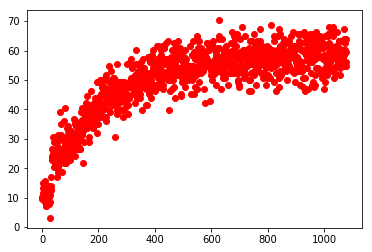

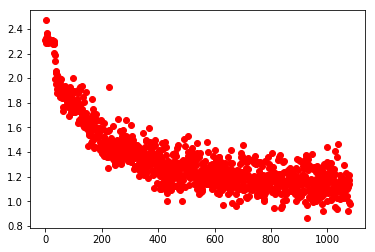

In [1]:
# 查看训练过程的信息
import  matplotlib.pyplot as plt

def parse(in_file,flag):
    num=-1
    ys=list()
    xs=list()
    losses=list()
    with open(in_file,"r") as reader:
        for aLine in reader:
            #print(aLine)

            res=[e for e in aLine.strip('\n').split(" ")]
            if res[0]=="Train" and flag=="Train":
                num=num+1
                ys.append(float(res[-1]))
                xs.append(int(num))
                losses.append(float(res[-3].split(',')[0]))
            if res[0]=="Validation" and flag=="Validation":
                num=num+1
                xs.append(int(num))
                tmp=[float(e) for e in res[-2].split('/')]
                ys.append(100*float(tmp[0]/tmp[1]))
                losses.append(float(res[-4].split(',')[0]))

    plt.figure(1)
    plt.plot(xs,ys,'ro')


    plt.figure(2)
    plt.plot(xs, losses, 'ro')
    plt.show()

def main():
    in_file="D://INFO.txt"
    # 显示训练阶段的正确率和Loss信息
    parse(in_file,"Train") # "Validation"
    # 显示验证阶段的正确率和Loss信息
    #parse(in_file,"Validation") # "Validation"


if __name__=="__main__":
    main()

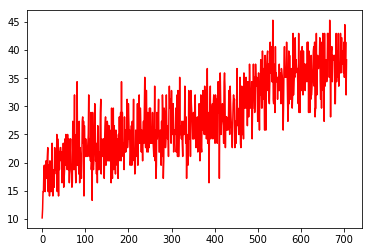

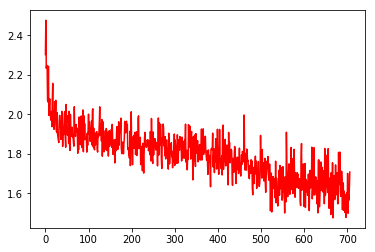

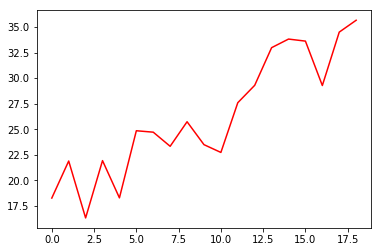

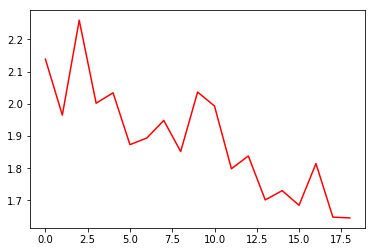

In [3]:
# 查看训练过程的信息
import  matplotlib.pyplot as plt

def parse(in_file,flag):
    num=-1
    ys=list()
    xs=list()
    losses=list()
    with open(in_file,"r") as reader:
        for aLine in reader:
            #print(aLine)

            res=[e for e in aLine.strip('\n').split(" ")]
            if res[0]=="Train" and flag=="Train":
                num=num+1
                ys.append(float(res[-1]))
                xs.append(int(num))
                losses.append(float(res[-3].split(',')[0]))
            if res[0]=="Validation" and flag=="Validation":
                num=num+1
                xs.append(int(num))
                tmp=[float(e) for e in res[-2].split('/')]
                ys.append(100*float(tmp[0]/tmp[1]))
                losses.append(float(res[-4].split(',')[0]))

    plt.figure(1)
    plt.plot(xs,ys,'r-')


    plt.figure(2)
    plt.plot(xs, losses, 'r-')
    plt.show()

def main():
    in_file="D://INFO.txt"
    # 显示训练阶段的正确率和Loss信息
    parse(in_file,"Train") # "Validation"
    # 显示验证阶段的正确率和Loss信息
    parse(in_file,"Validation") # "Validation"


if __name__=="__main__":
    main()